## Importing Libraries

In [1]:
# !pip install torchsummary
import os
import time
import  tqdm
from collections import OrderedDict

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import random_split, DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [5]:
!python -m pip install torchsummary 
from torchsummary import summary

## Uploading the histology dataset

In [ ]:
class HistologyImageDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_names = os.listdir(root)
        self.images, self.targets = [], []
        
        for image_name in self.image_names:
            image_label = None
    
            if len(image_name[:image_name.find('_')]) == 6:
                image_label = 0
            elif len(image_name[:image_name.find('_')]) == 5:
                image_label = 1

            path = os.path.join(self.root, image_name)
            image = np.array(Image.open(path).convert("RGB"))

            self.images.append(Image.fromarray(image))
            self.targets.append(image_label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

In [ ]:
dataset = HistologyImageDataset(root='/kaggle/input/histology10k/img_TRAIN_FULL_8400', transform=transforms.Compose([
                                                                                                    transforms.Resize((224, 224)),
                                                                                                    transforms.RandomRotation([-30, 30]),
                                                                                                    transforms.RandomHorizontalFlip(),
                                                                                                    transforms.ToTensor(),
                ]))

In [ ]:
# no transforms for test_dataset
train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.7), int(len(dataset) * 0.3)])

In [7]:
# total_train_size = len(train_dataset)
# total_test_size = len(test_dataset)

batch_size = 16
hid_size = 1024
num_classes = 2

num_clients = 4
rounds = 10
epochs_per_client = 3

learning_rate = 0.001

In [ ]:
print(f'Train dataset size: {total_train_size}')
print(f'Test dataset size: {total_test_size}')

In [ ]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

## GPU support

In [2]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_device()
device

device(type='cuda')

## Server&Client classes

In [10]:
def calculate_accuracy(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

def calculate_val_loss(model, data_generator):
    val_loss = []
    model.train(False)
    with torch.no_grad():
        for (X_batch, y_batch) in data_generator:
            # forward
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)

            cretetion = torch.nn.CrossEntropyLoss()
            loss = cretetion(predictions, y_batch)
            
            val_loss.append(loss.cpu().numpy())
            
    return np.mean(val_loss)

In [11]:
def train_epoch(model, dataset, batch_size, optimizer):
    train_loss = []
    train_data_generator = torch.utils.data.DataLoader(dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      num_workers=2)

    model.train(True) # enable dropout / batch_norm training behavior

    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()
        # forward
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)

        cretetion = torch.nn.CrossEntropyLoss()
        loss = cretetion(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())

    return np.mean(train_loss)


def train_loop(model, train_dataset, val_dataset, num_epochs, batch_size, optimizer, model_path):
    val_data_generator = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=2)

    history = {}
    history['train loss'] = []
    history['validation loss'] = []
    history['validation accuracy'] = []
        
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train_epoch(model, train_dataset, batch_size, optimizer)
        
        val_loss = calculate_val_loss(model, val_data_generator)
        val_accuracy = calculate_accuracy(model, val_data_generator)
        

        # Then we print the results for this epoch:
        print('Model: {}'.format(model.__class__.__name__))
        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        print('  training loss (in-iteration): \t{:.6f}'.format(train_loss))
        print('  validation loss (in-iteration): \t{:.6f}'.format(val_loss))
        print('  validation accuracy: \t\t\t{:.2f} %'.format(val_accuracy * 100))

        history['train loss'].append(train_loss) 
        history['validation loss'].append(val_loss) 
        history['validation accuracy'].append(val_accuracy)
        
        torch.save({
            'epoch': num_epochs + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'validation_accuracy': val_accuracy * 100,
            'validation_loss': val_loss
            },model_path)
              
    return history

In [12]:
class Server:
    def __init__(self, clients, model, dataset):
        self.clients = clients # dict
        self.model = model
        self.model.to(device)
        self.dataset = dataset
        # self.aggregate_layer_name = aggregate_layer_name
        
    def train_epoch(self, batch_size, optimizer):
        return train_epoch(self.model, self.dataset, batch_size, optimizer)

    def train_loop(self, val_dataset, num_epochs, batch_size, model_path):
        param_to_learn = [param for param in self.model.parameters() if param.requires_grad == True]
        optimizer = torch.optim.Adam(param_to_learn, lr=0.001)

        train_history = train_loop(model=self.model, train_dataset=self.dataset, val_dataset=val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, model_path=model_path)
        return train_history
    
    def get_shared_parameters(self):
        shared_parameters = dict.fromkeys((client.client_id for client in self.clients), [])

        for cur_client in self.clients:
            shared_parameters[cur_client.client_id] = cur_client.get_shared_parameters()

        return shared_parameters


    def agreggate(self, shared_parameters):
        with torch.no_grad():
            shared_parameters_data = torch.Tensor()
            shared_parameters_data = shared_parameters_data.to(device)

            for client_id, parameters in shared_parameters.items():
                for name, data in parameters.items():
                    shared_parameters_data = torch.cat((shared_parameters_data, data.unsqueeze_(dim=0)), dim=0)
                    
            # change to calling the self.model.self.aggregate_layer_name
            updated_parameters_data = self.model.classifier.aggregate(shared_parameters_data)

            index = 0

            for client_id, parameters in shared_parameters.items():
                for name, _ in parameters.items():
                    shared_parameters[client_id][name] = updated_parameters_data[index]
                    index += 1

    def set_shared_parameters(self, shared_parameters):
        for client_id, parameters in shared_parameters.items():
            self.clients[client_id].set_shared_parameters(parameters)
            

In [13]:
class Client:
    def __init__(self, client_id, model, dataset, shared_parameter_names):
        self.client_id = client_id
        self.__model = model
        self.__model.to(device)
        self.__dataset = dataset
        self.shared_parameter_names = shared_parameter_names
    
    
    def train_epoch(self, batch_size, optimizer):
        return train_epoch(self.__model, self.__dataset, batch_size, optimizer)

    def train_loop(self, val_dataset, num_epochs, batch_size, model_path):
        param_to_learn = [param for param in self.__model.parameters() if param.requires_grad == True]
        optimizer = torch.optim.Adam(param_to_learn, lr=0.001)

        train_history = train_loop(model=self.__model, train_dataset=self.__dataset, val_dataset=val_dataset, num_epochs=num_epochs, batch_size=batch_size, optimizer=optimizer, model_path=model_path)
        return train_history
    
    def get_shared_parameters(self):
        shared_parameters = {}

        for parameter_name in self.shared_parameter_names:
            parameter_data = self.__model.state_dict().get(parameter_name)
            shared_parameters.update({parameter_name: parameter_data})
    
        return shared_parameters

    def set_shared_parameters(self, shared_parameters):   
        with torch.no_grad():
            for name, data in shared_parameters.items():
                for model_param_name, param in self.__model.named_parameters():
                    if name in model_param_name:
                        param.copy_(data)  
        

## Defining clients and server

### Client models

In [14]:
# # https://medium.com/@golnaz.hosseini/beginner-tutorial-image-classification-using-pytorch-63f30dcc071c

# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()

#         self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
#         self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
#         self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
#         self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

#         self.fc =nn.Sequential(nn.Flatten(),
#                                nn.Linear(14*14*512, hid_size),
#                                nn.ReLU())
        
#         self.shared = nn.Linear(hid_size, hid_size)
        
#         self.classifier = nn.Sequential(nn.ReLU(),
#                                         nn.Linear(hid_size, num_classes))
    
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.fc(x)
#         x = self.shared(x)
#         x = self.classifier(x)
#         return x
    
#     def ConvModule(self, in_features, out_features):
#         return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
#                             nn.BatchNorm2d(out_features),
#                             nn.ReLU(),
#                             nn.MaxPool2d(2,2)
#                             )

In [15]:
# custom_model = CustomCNN()
# custom_model = custom_model.to(device)

In [3]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(16, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16928, hid_size)
        self.shared = nn.Linear(hid_size, hid_size)
        self.classifier = nn.Linear(hid_size, num_classes)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc(x))
        x = F.relu(self.shared(x))
        x = self.classifier(x)
        return x

In [8]:
simple_model = SimpleModel()
simple_model = simple_model.to(device)

In [9]:
summary(simple_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
         MaxPool2d-2           [-1, 16, 74, 74]               0
            Conv2d-3           [-1, 16, 72, 72]           2,320
            Conv2d-4           [-1, 32, 70, 70]           4,640
         MaxPool2d-5           [-1, 32, 23, 23]               0
           Flatten-6                [-1, 16928]               0
            Linear-7                 [-1, 1024]      17,335,296
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                    [-1, 2]           2,050
Total params: 18,394,354
Trainable params: 18,394,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 8.79
Params size (MB): 70.17
Estimated Total Size (MB): 79.53
-----------------------------------

In [12]:
print(simple_model)

SimpleModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=16928, out_features=1024, bias=True)
  (shared): Linear(in_features=1024, out_features=1024, bias=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)


In [18]:
# resnet18 = models.resnet18(pretrained=True, progress=True)

# for param in resnet18.parameters():
#   param.requires_grad = False

# for param in resnet18.fc.parameters():
#   param.requires_grad = True

# in_features = resnet18.fc.in_features
# resnet18.fc = nn.Sequential(OrderedDict([
#                             ('hid',nn.Linear(in_features, hid_size)),
#                             ('relu1', nn.ReLU()),
#                             ('shared', nn.Linear(hid_size, hid_size)),
#                             ('relu2', nn.ReLU()),
#                             ('classifier', nn.Linear(hid_size, num_classes))
#                             ]))

# resnet18 = resnet18.to(device)

In [16]:
densenet121 = models.densenet121(pretrained=True, progress=True)

for param in densenet121.parameters():
  param.requires_grad = False

for param in densenet121.classifier.parameters():
  param.requires_grad = True

in_features = densenet121.classifier.in_features
densenet121.classifier = nn.Sequential(OrderedDict([
                            ('fc', nn.Linear(in_features, hid_size)),
                            ('relu1', nn.ReLU()),
                            ('shared', nn.Linear(hid_size, hid_size)),
                            ('relu2', nn.ReLU()),
                            ('classifier', nn.Linear(hid_size, num_classes))
                            ]))

densenet121 = densenet121.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s] 


In [17]:
mobilenetv3_large = models.mobilenet_v3_large(pretrained=True, progress=True)

for param in mobilenetv3_large.parameters():
  param.requires_grad = False

for param in mobilenetv3_large.classifier.parameters():
  param.requires_grad = True

in_features = mobilenetv3_large.classifier[0].in_features
mobilenetv3_large.classifier = nn.Sequential(OrderedDict([
                            ('fc', nn.Linear(in_features, hid_size)),
                            ('relu1', nn.ReLU()),
                            ('shared', nn.Linear(hid_size, hid_size)),
                            ('relu2', nn.ReLU()),
                            ('classifier', nn.Linear(hid_size, num_classes))
                            ]))
mobilenetv3_large = mobilenetv3_large.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 141MB/s] 


In [18]:
mobilenetv3_small = models.mobilenet_v3_small(pretrained=True, progress=True)

for param in mobilenetv3_small.parameters():
  param.requires_grad = False

for param in mobilenetv3_small.classifier.parameters():
  param.requires_grad = True

in_features = mobilenetv3_small.classifier[0].in_features
mobilenetv3_small.classifier = nn.Sequential(OrderedDict([
                            ('fc', nn.Linear(in_features, hid_size)),
                            ('relu1', nn.ReLU()),
                            ('shared', nn.Linear(hid_size, hid_size)),
                            ('relu2', nn.ReLU()),
                            ('classifier', nn.Linear(hid_size, num_classes))
                            ]))
mobilenetv3_small = mobilenetv3_small.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 98.8MB/s]


In [19]:
# vit_l_16 = models.vit_l_16(pretrained=True, progress=True)

# for param in vit_l_16.parameters():
#   param.requires_grad = False

# for param in vit_l_16.heads.head.parameters():
#   param.requires_grad = True

# in_features = vit_l_16.heads.head.in_features
# vit_l_16.heads.head = nn.Sequential(OrderedDict([
#                                   ('fc', nn.Linear(in_features,  hid_size * hid_size)),
#                                   ('reshape', Reshape(-1, hid_size, hid_size)),
#                                   ('aggregate', nn.Sequential(
#                                     nn.Linear(hid_size, hid_size),
#                                     nn.ReLU())),
#                                   ('max_pool', nn.MaxPool2d(kernel_size=(hid_size, 1))),
#                                   ('squeeze', Squeeze()),
#                                   ('classifier', nn.Linear(hid_size, num_classes))
#                                 ]))

In [20]:
googlenet = models.googlenet(pretrained=True, progress=True)

for param in googlenet.parameters():
  param.requires_grad = False

for param in googlenet.fc.parameters():
  param.requires_grad = True

in_features = googlenet.fc.in_features

googlenet.fc = nn.Sequential(OrderedDict([
                            ('hid', nn.Linear(in_features, hid_size)),
                            ('relu1', nn.ReLU()),
                            ('shared', nn.Linear(hid_size, hid_size)),
                            ('relu2', nn.ReLU()),
                            ('classifier', nn.Linear(hid_size, num_classes))
                            ]))

googlenet = googlenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 200MB/s] 


In [21]:
# vgg16 = models.vgg16(pretrained=True, progress=True)

# for param in vgg16.parameters():
#   param.requires_grad = False

# for param in vgg16.classifier.parameters():
#   param.requires_grad = True

# in_features = vgg16.classifier[0].in_features

# vgg16.classifier = nn.Sequential(OrderedDict([
#                               ('fc', nn.Linear(in_features,  hid_size * hid_size)),
#                               ('reshape', Reshape(-1, hid_size, hid_size)),
#                               ('aggregate', nn.Sequential(
#                                 nn.Linear(hid_size, hid_size),
#                                 nn.ReLU())),
#                               ('max_pool', nn.MaxPool2d(kernel_size=(hid_size, 1))),
#                               ('squeeze', Squeeze()),
#                               ('classifier', nn.Linear(hid_size, num_classes))
#                             ]))

# vgg16 = vgg16.to(device)

### Global model

In [22]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.reshape(self.shape)
    
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

    def forward(self, x):
        return x.squeeze()

In [23]:
#global_model 

# efficientnet_b7 = models.efficientnet_b7(pretrained=True, progress=True)

# for param in efficientnet_b7.parameters():
#   param.requires_grad = False

# for param in efficientnet_b7.classifier.parameters():
#   param.requires_grad = True

# in_features = efficientnet_b7.classifier[1].in_features
# efficientnet_b7.classifier = nn.Sequential(OrderedDict([
#                                           ('fc', nn.Linear(in_features,  hid_size * hid_size)),
#                                           ('reshape', Reshape(-1, hid_size, hid_size)),
#                                           ('aggregate', nn.Sequential(
#                                             nn.Linear(hid_size, hid_size),
#                                             nn.ReLU())),
#                                           ('max_pool', nn.MaxPool2d(kernel_size=(hid_size, 1))),
#                                           ('squeeze', Squeeze()),
#                                           ('classifier', nn.Linear(hid_size, num_classes))
#                                         ]))

# efficientnet_b7 = efficientnet_b7.to(device)

resnet18 = models.resnet18(pretrained=True, progress=True)

for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True

in_features = resnet18.fc.in_features
resnet18.classifier = nn.Sequential(OrderedDict([
                                  ('fc', nn.Linear(in_features,  hid_size * hid_size)),
                                  ('reshape', Reshape(-1, hid_size, hid_size)),
                                  ('aggregate', nn.Sequential(
                                    nn.Linear(hid_size, hid_size),
                                    nn.ReLU())),
                                  ('max_pool', nn.MaxPool2d(kernel_size=(hid_size, 1))),
                                  ('squeeze', Squeeze()),
                                  ('classifier', nn.Linear(hid_size, num_classes))
                                ]))

resnet18 = resnet18.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s] 


In [24]:
server_model = resnet18

## Basic training mode

In [25]:
!mkdir '/kaggle/working/basic_models'
!mkdir '/kaggle/working/federated_models'

In [26]:
examples_amount_per_client = total_train_size // (num_clients + 1)
splited_train_dataset = random_split(train_dataset, [examples_amount_per_client for i in range(num_clients + 1)])

In [27]:
print(examples_amount_per_client)

1176


In [34]:
simple_model_0 = SimpleModel()
simple_model_0 = simple_model_0.to(device)

simple_model_1 = SimpleModel()
simple_model_1 = simple_model_1.to(device)

simple_model_2 = SimpleModel()
simple_model_2 = simple_model_2.to(device)

simple_model_3 = SimpleModel()
simple_model_3 = simple_model_3.to(device)

In [29]:
# # rename clients to basic_clients
# basic_clients = []
# basic_clients.append(Client(client_id=0, model=simple_model, dataset=splited_train_dataset[0], shared_parameter_names=['shared.weight']))
# basic_clients.append(Client(client_id=1, model=mobilenetv3_small, dataset=splited_train_dataset[1], shared_parameter_names=['classifier.shared.weight']))
# basic_clients.append(Client(client_id=2, model=mobilenetv3_large, dataset=splited_train_dataset[2], shared_parameter_names=['classifier.shared.weight']))
# basic_clients.append(Client(client_id=3, model=densenet121, dataset=splited_train_dataset[3], shared_parameter_names=['classifier.shared.weight']))

# rename clients to basic_clients
basic_clients = []
basic_clients.append(Client(client_id=0, model=simple_model_0, dataset=splited_train_dataset[0], shared_parameter_names=['shared.weight']))
basic_clients.append(Client(client_id=1, model=simple_model_1, dataset=splited_train_dataset[1], shared_parameter_names=['shared.weight']))
basic_clients.append(Client(client_id=2, model=simple_model_2, dataset=splited_train_dataset[2], shared_parameter_names=['shared.weight']))
basic_clients.append(Client(client_id=3, model=simple_model_3, dataset=splited_train_dataset[3], shared_parameter_names=['shared.weight']))

In [30]:
basic_clients_history = dict((client.client_id, {'train loss': [], 'validation loss': [], 'validation accuracy': []})  for client in basic_clients)

In [32]:
for client in basic_clients:
    basic_clients_history[client.client_id] = client.train_loop(val_dataset=test_dataset, num_epochs=rounds*epochs_per_client, batch_size=16, model_path=f'/kaggle/working/basic_models/client_id_{client.client_id}.pt')

100%|██████████| 74/74 [00:09<00:00,  8.17it/s]


Model: SimpleModel
Epoch 1 of 30 took 16.208s
  training loss (in-iteration): 	0.412358
  validation loss (in-iteration): 	0.168725
  validation accuracy: 			95.13 %


100%|██████████| 74/74 [00:02<00:00, 36.85it/s]


Model: SimpleModel
Epoch 2 of 30 took 9.314s
  training loss (in-iteration): 	0.193196
  validation loss (in-iteration): 	0.254529
  validation accuracy: 			91.42 %


100%|██████████| 74/74 [00:02<00:00, 33.28it/s]


Model: SimpleModel
Epoch 3 of 30 took 9.880s
  training loss (in-iteration): 	0.155280
  validation loss (in-iteration): 	0.133870
  validation accuracy: 			95.41 %


100%|██████████| 74/74 [00:02<00:00, 36.24it/s]


Model: SimpleModel
Epoch 4 of 30 took 9.253s
  training loss (in-iteration): 	0.184514
  validation loss (in-iteration): 	0.108884
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:02<00:00, 35.42it/s]


Model: SimpleModel
Epoch 5 of 30 took 9.085s
  training loss (in-iteration): 	0.141452
  validation loss (in-iteration): 	0.254674
  validation accuracy: 			92.92 %


100%|██████████| 74/74 [00:01<00:00, 37.32it/s]


Model: SimpleModel
Epoch 6 of 30 took 9.012s
  training loss (in-iteration): 	0.156478
  validation loss (in-iteration): 	0.093503
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:01<00:00, 38.24it/s]


Model: SimpleModel
Epoch 7 of 30 took 8.967s
  training loss (in-iteration): 	0.154369
  validation loss (in-iteration): 	0.154679
  validation accuracy: 			93.71 %


100%|██████████| 74/74 [00:02<00:00, 36.90it/s]


Model: SimpleModel
Epoch 8 of 30 took 9.117s
  training loss (in-iteration): 	0.113260
  validation loss (in-iteration): 	0.089041
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:01<00:00, 37.68it/s]


Model: SimpleModel
Epoch 9 of 30 took 9.021s
  training loss (in-iteration): 	0.113778
  validation loss (in-iteration): 	0.117382
  validation accuracy: 			95.61 %


100%|██████████| 74/74 [00:02<00:00, 35.32it/s]


Model: SimpleModel
Epoch 10 of 30 took 9.265s
  training loss (in-iteration): 	0.100824
  validation loss (in-iteration): 	0.081329
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 37.95it/s]


Model: SimpleModel
Epoch 11 of 30 took 9.224s
  training loss (in-iteration): 	0.152214
  validation loss (in-iteration): 	0.087524
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 37.52it/s]


Model: SimpleModel
Epoch 12 of 30 took 9.070s
  training loss (in-iteration): 	0.114413
  validation loss (in-iteration): 	0.090349
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 37.52it/s]


Model: SimpleModel
Epoch 13 of 30 took 9.424s
  training loss (in-iteration): 	0.099626
  validation loss (in-iteration): 	0.089282
  validation accuracy: 			96.52 %


100%|██████████| 74/74 [00:02<00:00, 34.81it/s]


Model: SimpleModel
Epoch 14 of 30 took 9.356s
  training loss (in-iteration): 	0.117325
  validation loss (in-iteration): 	0.089639
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 37.86it/s]


Model: SimpleModel
Epoch 15 of 30 took 8.976s
  training loss (in-iteration): 	0.131084
  validation loss (in-iteration): 	0.089206
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 38.67it/s]


Model: SimpleModel
Epoch 16 of 30 took 9.475s
  training loss (in-iteration): 	0.094190
  validation loss (in-iteration): 	0.084940
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:01<00:00, 37.07it/s]


Model: SimpleModel
Epoch 17 of 30 took 9.035s
  training loss (in-iteration): 	0.138710
  validation loss (in-iteration): 	0.149585
  validation accuracy: 			95.53 %


100%|██████████| 74/74 [00:02<00:00, 35.52it/s]


Model: SimpleModel
Epoch 18 of 30 took 9.105s
  training loss (in-iteration): 	0.118944
  validation loss (in-iteration): 	0.097078
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:02<00:00, 36.89it/s]


Model: SimpleModel
Epoch 19 of 30 took 9.555s
  training loss (in-iteration): 	0.112997
  validation loss (in-iteration): 	0.092239
  validation accuracy: 			96.52 %


100%|██████████| 74/74 [00:01<00:00, 38.84it/s]


Model: SimpleModel
Epoch 20 of 30 took 8.954s
  training loss (in-iteration): 	0.091364
  validation loss (in-iteration): 	0.086681
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:01<00:00, 37.60it/s]


Model: SimpleModel
Epoch 21 of 30 took 9.170s
  training loss (in-iteration): 	0.089995
  validation loss (in-iteration): 	0.111154
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:01<00:00, 37.30it/s]


Model: SimpleModel
Epoch 22 of 30 took 9.108s
  training loss (in-iteration): 	0.089525
  validation loss (in-iteration): 	0.091784
  validation accuracy: 			97.19 %


100%|██████████| 74/74 [00:02<00:00, 33.09it/s]


Model: SimpleModel
Epoch 23 of 30 took 9.366s
  training loss (in-iteration): 	0.085607
  validation loss (in-iteration): 	0.106926
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:02<00:00, 36.83it/s]


Model: SimpleModel
Epoch 24 of 30 took 9.115s
  training loss (in-iteration): 	0.078182
  validation loss (in-iteration): 	0.086346
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:02<00:00, 36.64it/s]


Model: SimpleModel
Epoch 25 of 30 took 9.009s
  training loss (in-iteration): 	0.084483
  validation loss (in-iteration): 	0.078303
  validation accuracy: 			97.03 %


100%|██████████| 74/74 [00:01<00:00, 37.20it/s]


Model: SimpleModel
Epoch 26 of 30 took 9.536s
  training loss (in-iteration): 	0.096046
  validation loss (in-iteration): 	0.111691
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:01<00:00, 37.27it/s]


Model: SimpleModel
Epoch 27 of 30 took 9.194s
  training loss (in-iteration): 	0.103191
  validation loss (in-iteration): 	0.106799
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:01<00:00, 38.40it/s]


Model: SimpleModel
Epoch 28 of 30 took 9.060s
  training loss (in-iteration): 	0.106228
  validation loss (in-iteration): 	0.092892
  validation accuracy: 			96.16 %


100%|██████████| 74/74 [00:02<00:00, 36.36it/s]


Model: SimpleModel
Epoch 29 of 30 took 9.533s
  training loss (in-iteration): 	0.085041
  validation loss (in-iteration): 	0.103337
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:01<00:00, 38.17it/s]


Model: SimpleModel
Epoch 30 of 30 took 9.228s
  training loss (in-iteration): 	0.081165
  validation loss (in-iteration): 	0.084560
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 37.22it/s]


Model: SimpleModel
Epoch 1 of 30 took 9.020s
  training loss (in-iteration): 	0.373176
  validation loss (in-iteration): 	0.152799
  validation accuracy: 			95.21 %


100%|██████████| 74/74 [00:01<00:00, 38.53it/s]


Model: SimpleModel
Epoch 2 of 30 took 9.091s
  training loss (in-iteration): 	0.149420
  validation loss (in-iteration): 	0.102572
  validation accuracy: 			96.00 %


100%|██████████| 74/74 [00:01<00:00, 37.77it/s]


Model: SimpleModel
Epoch 3 of 30 took 8.935s
  training loss (in-iteration): 	0.176884
  validation loss (in-iteration): 	0.170672
  validation accuracy: 			91.34 %


100%|██████████| 74/74 [00:02<00:00, 36.84it/s]


Model: SimpleModel
Epoch 4 of 30 took 9.054s
  training loss (in-iteration): 	0.150442
  validation loss (in-iteration): 	0.180760
  validation accuracy: 			91.65 %


100%|██████████| 74/74 [00:02<00:00, 35.86it/s]


Model: SimpleModel
Epoch 5 of 30 took 9.199s
  training loss (in-iteration): 	0.114806
  validation loss (in-iteration): 	0.139676
  validation accuracy: 			93.71 %


100%|██████████| 74/74 [00:02<00:00, 34.52it/s]


Model: SimpleModel
Epoch 6 of 30 took 9.496s
  training loss (in-iteration): 	0.113439
  validation loss (in-iteration): 	0.110291
  validation accuracy: 			95.21 %


100%|██████████| 74/74 [00:01<00:00, 38.23it/s]


Model: SimpleModel
Epoch 7 of 30 took 9.110s
  training loss (in-iteration): 	0.119450
  validation loss (in-iteration): 	0.090142
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:01<00:00, 38.58it/s]


Model: SimpleModel
Epoch 8 of 30 took 8.837s
  training loss (in-iteration): 	0.114474
  validation loss (in-iteration): 	0.094796
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:02<00:00, 36.59it/s]


Model: SimpleModel
Epoch 9 of 30 took 9.330s
  training loss (in-iteration): 	0.096683
  validation loss (in-iteration): 	0.131384
  validation accuracy: 			95.89 %


100%|██████████| 74/74 [00:01<00:00, 37.70it/s]


Model: SimpleModel
Epoch 10 of 30 took 8.916s
  training loss (in-iteration): 	0.107236
  validation loss (in-iteration): 	0.149004
  validation accuracy: 			94.26 %


100%|██████████| 74/74 [00:01<00:00, 37.48it/s]


Model: SimpleModel
Epoch 11 of 30 took 9.028s
  training loss (in-iteration): 	0.088883
  validation loss (in-iteration): 	0.119153
  validation accuracy: 			95.37 %


100%|██████████| 74/74 [00:01<00:00, 37.84it/s]


Model: SimpleModel
Epoch 12 of 30 took 9.389s
  training loss (in-iteration): 	0.089938
  validation loss (in-iteration): 	0.113505
  validation accuracy: 			96.16 %


100%|██████████| 74/74 [00:02<00:00, 36.47it/s]


Model: SimpleModel
Epoch 13 of 30 took 8.930s
  training loss (in-iteration): 	0.080180
  validation loss (in-iteration): 	0.099618
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 38.03it/s]


Model: SimpleModel
Epoch 14 of 30 took 8.931s
  training loss (in-iteration): 	0.088772
  validation loss (in-iteration): 	0.113897
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:01<00:00, 37.73it/s]


Model: SimpleModel
Epoch 15 of 30 took 9.109s
  training loss (in-iteration): 	0.099554
  validation loss (in-iteration): 	0.111766
  validation accuracy: 			96.40 %


100%|██████████| 74/74 [00:02<00:00, 33.93it/s]


Model: SimpleModel
Epoch 16 of 30 took 9.221s
  training loss (in-iteration): 	0.084857
  validation loss (in-iteration): 	0.090787
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:01<00:00, 37.73it/s]


Model: SimpleModel
Epoch 17 of 30 took 9.007s
  training loss (in-iteration): 	0.075763
  validation loss (in-iteration): 	0.098095
  validation accuracy: 			95.81 %


100%|██████████| 74/74 [00:02<00:00, 36.74it/s]


Model: SimpleModel
Epoch 18 of 30 took 9.114s
  training loss (in-iteration): 	0.078356
  validation loss (in-iteration): 	0.154171
  validation accuracy: 			94.98 %


100%|██████████| 74/74 [00:01<00:00, 37.76it/s]


Model: SimpleModel
Epoch 19 of 30 took 9.345s
  training loss (in-iteration): 	0.080876
  validation loss (in-iteration): 	0.095152
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 37.51it/s]


Model: SimpleModel
Epoch 20 of 30 took 9.286s
  training loss (in-iteration): 	0.078806
  validation loss (in-iteration): 	0.101579
  validation accuracy: 			95.89 %


100%|██████████| 74/74 [00:02<00:00, 36.85it/s]


Model: SimpleModel
Epoch 21 of 30 took 9.144s
  training loss (in-iteration): 	0.088909
  validation loss (in-iteration): 	0.094844
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:01<00:00, 38.33it/s]


Model: SimpleModel
Epoch 22 of 30 took 9.513s
  training loss (in-iteration): 	0.075656
  validation loss (in-iteration): 	0.114791
  validation accuracy: 			95.85 %


100%|██████████| 74/74 [00:01<00:00, 37.73it/s]


Model: SimpleModel
Epoch 23 of 30 took 9.040s
  training loss (in-iteration): 	0.070596
  validation loss (in-iteration): 	0.106625
  validation accuracy: 			96.00 %


100%|██████████| 74/74 [00:01<00:00, 37.84it/s]


Model: SimpleModel
Epoch 24 of 30 took 9.224s
  training loss (in-iteration): 	0.051507
  validation loss (in-iteration): 	0.154560
  validation accuracy: 			94.82 %


100%|██████████| 74/74 [00:02<00:00, 35.81it/s]


Model: SimpleModel
Epoch 25 of 30 took 9.505s
  training loss (in-iteration): 	0.078656
  validation loss (in-iteration): 	0.149322
  validation accuracy: 			93.04 %


100%|██████████| 74/74 [00:02<00:00, 35.67it/s]


Model: SimpleModel
Epoch 26 of 30 took 9.085s
  training loss (in-iteration): 	0.086027
  validation loss (in-iteration): 	0.130752
  validation accuracy: 			94.98 %


100%|██████████| 74/74 [00:02<00:00, 36.23it/s]


Model: SimpleModel
Epoch 27 of 30 took 9.125s
  training loss (in-iteration): 	0.089423
  validation loss (in-iteration): 	0.103727
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:01<00:00, 38.51it/s]


Model: SimpleModel
Epoch 28 of 30 took 9.184s
  training loss (in-iteration): 	0.076446
  validation loss (in-iteration): 	0.167978
  validation accuracy: 			94.98 %


100%|██████████| 74/74 [00:01<00:00, 37.06it/s]


Model: SimpleModel
Epoch 29 of 30 took 9.013s
  training loss (in-iteration): 	0.109655
  validation loss (in-iteration): 	0.242239
  validation accuracy: 			94.50 %


100%|██████████| 74/74 [00:01<00:00, 37.28it/s]


Model: SimpleModel
Epoch 30 of 30 took 9.142s
  training loss (in-iteration): 	0.089858
  validation loss (in-iteration): 	0.097989
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:02<00:00, 36.51it/s]


Model: SimpleModel
Epoch 1 of 30 took 9.179s
  training loss (in-iteration): 	0.317161
  validation loss (in-iteration): 	0.303774
  validation accuracy: 			82.28 %


100%|██████████| 74/74 [00:02<00:00, 32.86it/s]


Model: SimpleModel
Epoch 2 of 30 took 9.395s
  training loss (in-iteration): 	0.247186
  validation loss (in-iteration): 	0.404377
  validation accuracy: 			82.04 %


100%|██████████| 74/74 [00:02<00:00, 36.52it/s]


Model: SimpleModel
Epoch 3 of 30 took 9.067s
  training loss (in-iteration): 	0.181410
  validation loss (in-iteration): 	0.145047
  validation accuracy: 			94.15 %


100%|██████████| 74/74 [00:01<00:00, 37.58it/s]


Model: SimpleModel
Epoch 4 of 30 took 9.031s
  training loss (in-iteration): 	0.166652
  validation loss (in-iteration): 	0.144819
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 35.41it/s]


Model: SimpleModel
Epoch 5 of 30 took 9.526s
  training loss (in-iteration): 	0.138242
  validation loss (in-iteration): 	0.109337
  validation accuracy: 			96.00 %


100%|██████████| 74/74 [00:01<00:00, 38.23it/s]


Model: SimpleModel
Epoch 6 of 30 took 9.001s
  training loss (in-iteration): 	0.120463
  validation loss (in-iteration): 	0.099987
  validation accuracy: 			96.20 %


100%|██████████| 74/74 [00:01<00:00, 38.51it/s]


Model: SimpleModel
Epoch 7 of 30 took 8.976s
  training loss (in-iteration): 	0.147283
  validation loss (in-iteration): 	0.120263
  validation accuracy: 			96.04 %


100%|██████████| 74/74 [00:01<00:00, 38.24it/s]


Model: SimpleModel
Epoch 8 of 30 took 9.373s
  training loss (in-iteration): 	0.146794
  validation loss (in-iteration): 	0.107642
  validation accuracy: 			96.16 %


100%|██████████| 74/74 [00:01<00:00, 37.88it/s]


Model: SimpleModel
Epoch 9 of 30 took 9.018s
  training loss (in-iteration): 	0.114558
  validation loss (in-iteration): 	0.099048
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:02<00:00, 35.17it/s]


Model: SimpleModel
Epoch 10 of 30 took 9.191s
  training loss (in-iteration): 	0.110384
  validation loss (in-iteration): 	0.137673
  validation accuracy: 			94.62 %


100%|██████████| 74/74 [00:01<00:00, 37.07it/s]


Model: SimpleModel
Epoch 11 of 30 took 9.379s
  training loss (in-iteration): 	0.095652
  validation loss (in-iteration): 	0.146269
  validation accuracy: 			94.74 %


100%|██████████| 74/74 [00:01<00:00, 38.62it/s]


Model: SimpleModel
Epoch 12 of 30 took 9.036s
  training loss (in-iteration): 	0.097926
  validation loss (in-iteration): 	0.089497
  validation accuracy: 			96.80 %


100%|██████████| 74/74 [00:02<00:00, 35.54it/s]


Model: SimpleModel
Epoch 13 of 30 took 9.112s
  training loss (in-iteration): 	0.125412
  validation loss (in-iteration): 	0.146078
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:02<00:00, 36.87it/s]


Model: SimpleModel
Epoch 14 of 30 took 9.348s
  training loss (in-iteration): 	0.111828
  validation loss (in-iteration): 	0.105645
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 34.79it/s]


Model: SimpleModel
Epoch 15 of 30 took 9.372s
  training loss (in-iteration): 	0.092800
  validation loss (in-iteration): 	0.121280
  validation accuracy: 			95.93 %


100%|██████████| 74/74 [00:02<00:00, 36.95it/s]


Model: SimpleModel
Epoch 16 of 30 took 9.229s
  training loss (in-iteration): 	0.080368
  validation loss (in-iteration): 	0.098211
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:01<00:00, 38.35it/s]


Model: SimpleModel
Epoch 17 of 30 took 9.105s
  training loss (in-iteration): 	0.099416
  validation loss (in-iteration): 	0.130317
  validation accuracy: 			94.58 %


100%|██████████| 74/74 [00:02<00:00, 35.44it/s]


Model: SimpleModel
Epoch 18 of 30 took 9.423s
  training loss (in-iteration): 	0.074077
  validation loss (in-iteration): 	0.160745
  validation accuracy: 			95.02 %


100%|██████████| 74/74 [00:02<00:00, 36.89it/s]


Model: SimpleModel
Epoch 19 of 30 took 9.061s
  training loss (in-iteration): 	0.073775
  validation loss (in-iteration): 	0.086335
  validation accuracy: 			96.52 %


100%|██████████| 74/74 [00:01<00:00, 37.11it/s]


Model: SimpleModel
Epoch 20 of 30 took 9.048s
  training loss (in-iteration): 	0.093401
  validation loss (in-iteration): 	0.104433
  validation accuracy: 			96.20 %


100%|██████████| 74/74 [00:01<00:00, 37.46it/s]


Model: SimpleModel
Epoch 21 of 30 took 9.378s
  training loss (in-iteration): 	0.142274
  validation loss (in-iteration): 	0.108287
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:01<00:00, 38.30it/s]


Model: SimpleModel
Epoch 22 of 30 took 9.035s
  training loss (in-iteration): 	0.082856
  validation loss (in-iteration): 	0.093745
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:02<00:00, 35.68it/s]


Model: SimpleModel
Epoch 23 of 30 took 9.157s
  training loss (in-iteration): 	0.085496
  validation loss (in-iteration): 	0.116458
  validation accuracy: 			94.62 %


100%|██████████| 74/74 [00:02<00:00, 34.87it/s]


Model: SimpleModel
Epoch 24 of 30 took 9.354s
  training loss (in-iteration): 	0.108222
  validation loss (in-iteration): 	0.117209
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:01<00:00, 37.40it/s]


Model: SimpleModel
Epoch 25 of 30 took 9.081s
  training loss (in-iteration): 	0.092936
  validation loss (in-iteration): 	0.094227
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:02<00:00, 36.48it/s]


Model: SimpleModel
Epoch 26 of 30 took 9.109s
  training loss (in-iteration): 	0.091747
  validation loss (in-iteration): 	0.091564
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 37.77it/s]


Model: SimpleModel
Epoch 27 of 30 took 9.113s
  training loss (in-iteration): 	0.083331
  validation loss (in-iteration): 	0.099913
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:02<00:00, 35.03it/s]


Model: SimpleModel
Epoch 28 of 30 took 9.254s
  training loss (in-iteration): 	0.063852
  validation loss (in-iteration): 	0.084098
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:01<00:00, 37.90it/s]


Model: SimpleModel
Epoch 29 of 30 took 8.962s
  training loss (in-iteration): 	0.077546
  validation loss (in-iteration): 	0.150864
  validation accuracy: 			94.66 %


100%|██████████| 74/74 [00:01<00:00, 37.53it/s]


Model: SimpleModel
Epoch 30 of 30 took 9.076s
  training loss (in-iteration): 	0.069343
  validation loss (in-iteration): 	0.095284
  validation accuracy: 			96.08 %


100%|██████████| 74/74 [00:01<00:00, 38.27it/s]


Model: SimpleModel
Epoch 1 of 30 took 9.432s
  training loss (in-iteration): 	0.320651
  validation loss (in-iteration): 	0.161456
  validation accuracy: 			92.44 %


100%|██████████| 74/74 [00:02<00:00, 36.06it/s]


Model: SimpleModel
Epoch 2 of 30 took 9.225s
  training loss (in-iteration): 	0.163552
  validation loss (in-iteration): 	0.192285
  validation accuracy: 			91.02 %


100%|██████████| 74/74 [00:01<00:00, 38.64it/s]


Model: SimpleModel
Epoch 3 of 30 took 9.154s
  training loss (in-iteration): 	0.158941
  validation loss (in-iteration): 	0.137551
  validation accuracy: 			94.94 %


100%|██████████| 74/74 [00:01<00:00, 38.07it/s]


Model: SimpleModel
Epoch 4 of 30 took 9.431s
  training loss (in-iteration): 	0.149293
  validation loss (in-iteration): 	0.223896
  validation accuracy: 			92.01 %


100%|██████████| 74/74 [00:01<00:00, 38.15it/s]


Model: SimpleModel
Epoch 5 of 30 took 9.097s
  training loss (in-iteration): 	0.147479
  validation loss (in-iteration): 	0.135261
  validation accuracy: 			95.02 %


100%|██████████| 74/74 [00:02<00:00, 34.76it/s]


Model: SimpleModel
Epoch 6 of 30 took 9.414s
  training loss (in-iteration): 	0.142548
  validation loss (in-iteration): 	0.105064
  validation accuracy: 			96.32 %


100%|██████████| 74/74 [00:01<00:00, 37.07it/s]


Model: SimpleModel
Epoch 7 of 30 took 9.089s
  training loss (in-iteration): 	0.133110
  validation loss (in-iteration): 	0.132895
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 37.53it/s]


Model: SimpleModel
Epoch 8 of 30 took 8.984s
  training loss (in-iteration): 	0.143934
  validation loss (in-iteration): 	0.236777
  validation accuracy: 			88.81 %


100%|██████████| 74/74 [00:01<00:00, 37.82it/s]


Model: SimpleModel
Epoch 9 of 30 took 9.259s
  training loss (in-iteration): 	0.160522
  validation loss (in-iteration): 	0.117536
  validation accuracy: 			95.81 %


100%|██████████| 74/74 [00:02<00:00, 36.54it/s]


Model: SimpleModel
Epoch 10 of 30 took 9.074s
  training loss (in-iteration): 	0.119113
  validation loss (in-iteration): 	0.103880
  validation accuracy: 			96.32 %


100%|██████████| 74/74 [00:02<00:00, 35.52it/s]


Model: SimpleModel
Epoch 11 of 30 took 9.148s
  training loss (in-iteration): 	0.113658
  validation loss (in-iteration): 	0.089240
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:02<00:00, 35.83it/s]


Model: SimpleModel
Epoch 12 of 30 took 9.556s
  training loss (in-iteration): 	0.111449
  validation loss (in-iteration): 	0.096834
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:02<00:00, 35.76it/s]


Model: SimpleModel
Epoch 13 of 30 took 9.218s
  training loss (in-iteration): 	0.096175
  validation loss (in-iteration): 	0.143773
  validation accuracy: 			94.78 %


100%|██████████| 74/74 [00:02<00:00, 36.17it/s]


Model: SimpleModel
Epoch 14 of 30 took 9.321s
  training loss (in-iteration): 	0.116578
  validation loss (in-iteration): 	0.137981
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 36.84it/s]


Model: SimpleModel
Epoch 15 of 30 took 9.210s
  training loss (in-iteration): 	0.101327
  validation loss (in-iteration): 	0.091665
  validation accuracy: 			95.89 %


100%|██████████| 74/74 [00:02<00:00, 35.98it/s]


Model: SimpleModel
Epoch 16 of 30 took 9.047s
  training loss (in-iteration): 	0.108269
  validation loss (in-iteration): 	0.109964
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:01<00:00, 37.02it/s]


Model: SimpleModel
Epoch 17 of 30 took 9.234s
  training loss (in-iteration): 	0.104071
  validation loss (in-iteration): 	0.085230
  validation accuracy: 			96.52 %


100%|██████████| 74/74 [00:02<00:00, 36.92it/s]


Model: SimpleModel
Epoch 18 of 30 took 9.090s
  training loss (in-iteration): 	0.098426
  validation loss (in-iteration): 	0.106111
  validation accuracy: 			96.20 %


100%|██████████| 74/74 [00:01<00:00, 38.36it/s]


Model: SimpleModel
Epoch 19 of 30 took 9.002s
  training loss (in-iteration): 	0.105181
  validation loss (in-iteration): 	0.126470
  validation accuracy: 			94.98 %


100%|██████████| 74/74 [00:02<00:00, 35.16it/s]


Model: SimpleModel
Epoch 20 of 30 took 9.352s
  training loss (in-iteration): 	0.116886
  validation loss (in-iteration): 	0.159106
  validation accuracy: 			93.51 %


100%|██████████| 74/74 [00:01<00:00, 37.73it/s]


Model: SimpleModel
Epoch 21 of 30 took 9.052s
  training loss (in-iteration): 	0.107965
  validation loss (in-iteration): 	0.094709
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:01<00:00, 37.90it/s]


Model: SimpleModel
Epoch 22 of 30 took 9.049s
  training loss (in-iteration): 	0.107305
  validation loss (in-iteration): 	0.103870
  validation accuracy: 			96.12 %


100%|██████████| 74/74 [00:01<00:00, 37.34it/s]


Model: SimpleModel
Epoch 23 of 30 took 9.092s
  training loss (in-iteration): 	0.098133
  validation loss (in-iteration): 	0.081069
  validation accuracy: 			97.03 %


100%|██████████| 74/74 [00:02<00:00, 34.92it/s]


Model: SimpleModel
Epoch 24 of 30 took 9.229s
  training loss (in-iteration): 	0.094347
  validation loss (in-iteration): 	0.084120
  validation accuracy: 			97.07 %


100%|██████████| 74/74 [00:01<00:00, 37.91it/s]


Model: SimpleModel
Epoch 25 of 30 took 9.194s
  training loss (in-iteration): 	0.107365
  validation loss (in-iteration): 	0.083201
  validation accuracy: 			97.03 %


100%|██████████| 74/74 [00:02<00:00, 35.23it/s]


Model: SimpleModel
Epoch 26 of 30 took 9.023s
  training loss (in-iteration): 	0.082145
  validation loss (in-iteration): 	0.106239
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:01<00:00, 37.39it/s]


Model: SimpleModel
Epoch 27 of 30 took 9.401s
  training loss (in-iteration): 	0.095905
  validation loss (in-iteration): 	0.144384
  validation accuracy: 			94.50 %


100%|██████████| 74/74 [00:01<00:00, 37.98it/s]


Model: SimpleModel
Epoch 28 of 30 took 8.848s
  training loss (in-iteration): 	0.099253
  validation loss (in-iteration): 	0.110805
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 38.49it/s]


Model: SimpleModel
Epoch 29 of 30 took 8.894s
  training loss (in-iteration): 	0.108461
  validation loss (in-iteration): 	0.421833
  validation accuracy: 			81.76 %


100%|██████████| 74/74 [00:02<00:00, 36.36it/s]


Model: SimpleModel
Epoch 30 of 30 took 9.390s
  training loss (in-iteration): 	0.131874
  validation loss (in-iteration): 	0.158402
  validation accuracy: 			95.49 %


In [33]:
basic_clients_history

{0: {'train loss': [0.41235778,
   0.19319561,
   0.15528043,
   0.18451428,
   0.14145155,
   0.15647751,
   0.15436871,
   0.113260485,
   0.11377756,
   0.10082421,
   0.15221363,
   0.114412695,
   0.09962562,
   0.11732456,
   0.13108411,
   0.0941904,
   0.13870986,
   0.11894359,
   0.112996615,
   0.09136424,
   0.089994594,
   0.08952518,
   0.08560654,
   0.078182474,
   0.08448277,
   0.096046425,
   0.103191264,
   0.10622789,
   0.085041076,
   0.081165224],
  'validation loss': [0.1687251,
   0.25452945,
   0.13387035,
   0.10888428,
   0.25467354,
   0.09350344,
   0.15467943,
   0.08904138,
   0.11738162,
   0.0813289,
   0.0875237,
   0.09034877,
   0.089281686,
   0.08963903,
   0.08920597,
   0.08493975,
   0.14958459,
   0.09707831,
   0.09223932,
   0.08668119,
   0.111154035,
   0.091784224,
   0.106925905,
   0.08634569,
   0.07830279,
   0.11169101,
   0.10679885,
   0.092891805,
   0.103337,
   0.08455973],
  'validation accuracy': [0.9513449367088608,
   0.914

## Federated training mode
### # don't forget to reload client models and recreate clients

In [35]:
# fedarated_clients = []
# fedarated_clients.append(Client(client_id=0, model=simple_model, dataset=splited_train_dataset[0], shared_parameter_names=['shared.weight']))
# fedarated_clients.append(Client(client_id=1, model=mobilenetv3_small, dataset=splited_train_dataset[1], shared_parameter_names=['classifier.shared.weight']))
# fedarated_clients.append(Client(client_id=2, model=mobilenetv3_large, dataset=splited_train_dataset[2], shared_parameter_names=['classifier.shared.weight']))
# fedarated_clients.append(Client(client_id=3, model=densenet121, dataset=splited_train_dataset[3], shared_parameter_names=['classifier.shared.weight']))


fedarated_clients = []
fedarated_clients.append(Client(client_id=0, model=simple_model_0, dataset=splited_train_dataset[0], shared_parameter_names=['shared.weight']))
fedarated_clients.append(Client(client_id=1, model=simple_model_1, dataset=splited_train_dataset[1], shared_parameter_names=['shared.weight']))
fedarated_clients.append(Client(client_id=2, model=simple_model_2, dataset=splited_train_dataset[2], shared_parameter_names=['shared.weight']))
fedarated_clients.append(Client(client_id=3, model=simple_model_3, dataset=splited_train_dataset[3], shared_parameter_names=['shared.weight']))

In [36]:
server = Server(clients=fedarated_clients, model=server_model, dataset=splited_train_dataset[-1])

In [37]:
server_history = server.train_loop(val_dataset=test_dataset, num_epochs=30, batch_size=16, model_path='/kaggle/working/federated_models/server.pt')

100%|██████████| 74/74 [00:02<00:00, 30.90it/s]


Model: ResNet
Epoch 1 of 30 took 10.237s
  training loss (in-iteration): 	1.359747
  validation loss (in-iteration): 	0.372261
  validation accuracy: 			84.53 %


100%|██████████| 74/74 [00:02<00:00, 35.64it/s]


Model: ResNet
Epoch 2 of 30 took 10.162s
  training loss (in-iteration): 	0.305360
  validation loss (in-iteration): 	0.218621
  validation accuracy: 			92.48 %


100%|██████████| 74/74 [00:02<00:00, 36.31it/s]


Model: ResNet
Epoch 3 of 30 took 10.200s
  training loss (in-iteration): 	0.220395
  validation loss (in-iteration): 	0.161963
  validation accuracy: 			93.67 %


100%|██████████| 74/74 [00:01<00:00, 38.00it/s]


Model: ResNet
Epoch 4 of 30 took 10.176s
  training loss (in-iteration): 	0.177237
  validation loss (in-iteration): 	0.148716
  validation accuracy: 			95.21 %


100%|██████████| 74/74 [00:02<00:00, 35.68it/s]


Model: ResNet
Epoch 5 of 30 took 10.026s
  training loss (in-iteration): 	0.154717
  validation loss (in-iteration): 	0.132219
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 34.63it/s]


Model: ResNet
Epoch 6 of 30 took 10.078s
  training loss (in-iteration): 	0.129435
  validation loss (in-iteration): 	0.113227
  validation accuracy: 			96.08 %


100%|██████████| 74/74 [00:02<00:00, 36.32it/s]


Model: ResNet
Epoch 7 of 30 took 10.322s
  training loss (in-iteration): 	0.133021
  validation loss (in-iteration): 	0.125630
  validation accuracy: 			95.21 %


100%|██████████| 74/74 [00:02<00:00, 34.83it/s]


Model: ResNet
Epoch 8 of 30 took 10.348s
  training loss (in-iteration): 	0.120570
  validation loss (in-iteration): 	0.120511
  validation accuracy: 			95.81 %


100%|██████████| 74/74 [00:02<00:00, 34.86it/s]


Model: ResNet
Epoch 9 of 30 took 10.075s
  training loss (in-iteration): 	0.153209
  validation loss (in-iteration): 	0.131277
  validation accuracy: 			95.06 %


100%|██████████| 74/74 [00:02<00:00, 35.60it/s]


Model: ResNet
Epoch 10 of 30 took 10.364s
  training loss (in-iteration): 	0.110189
  validation loss (in-iteration): 	0.100109
  validation accuracy: 			96.12 %


100%|██████████| 74/74 [00:02<00:00, 34.81it/s]


Model: ResNet
Epoch 11 of 30 took 10.192s
  training loss (in-iteration): 	0.118681
  validation loss (in-iteration): 	0.091975
  validation accuracy: 			96.32 %


100%|██████████| 74/74 [00:01<00:00, 37.01it/s]


Model: ResNet
Epoch 12 of 30 took 9.838s
  training loss (in-iteration): 	0.127283
  validation loss (in-iteration): 	0.086518
  validation accuracy: 			96.32 %


100%|██████████| 74/74 [00:02<00:00, 36.02it/s]


Model: ResNet
Epoch 13 of 30 took 10.147s
  training loss (in-iteration): 	0.131643
  validation loss (in-iteration): 	0.087928
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:02<00:00, 35.63it/s]


Model: ResNet
Epoch 14 of 30 took 10.348s
  training loss (in-iteration): 	0.106769
  validation loss (in-iteration): 	0.085067
  validation accuracy: 			96.99 %


100%|██████████| 74/74 [00:02<00:00, 35.62it/s]


Model: ResNet
Epoch 15 of 30 took 10.007s
  training loss (in-iteration): 	0.079596
  validation loss (in-iteration): 	0.086986
  validation accuracy: 			97.35 %


100%|██████████| 74/74 [00:02<00:00, 35.09it/s]


Model: ResNet
Epoch 16 of 30 took 10.173s
  training loss (in-iteration): 	0.092054
  validation loss (in-iteration): 	0.077752
  validation accuracy: 			97.07 %


100%|██████████| 74/74 [00:02<00:00, 35.15it/s]


Model: ResNet
Epoch 17 of 30 took 10.172s
  training loss (in-iteration): 	0.075513
  validation loss (in-iteration): 	0.093758
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:02<00:00, 35.30it/s]


Model: ResNet
Epoch 18 of 30 took 10.184s
  training loss (in-iteration): 	0.082371
  validation loss (in-iteration): 	0.095961
  validation accuracy: 			95.89 %


100%|██████████| 74/74 [00:02<00:00, 36.27it/s]


Model: ResNet
Epoch 19 of 30 took 10.102s
  training loss (in-iteration): 	0.088864
  validation loss (in-iteration): 	0.079890
  validation accuracy: 			97.51 %


100%|██████████| 74/74 [00:02<00:00, 35.47it/s]


Model: ResNet
Epoch 20 of 30 took 10.024s
  training loss (in-iteration): 	0.096038
  validation loss (in-iteration): 	0.086448
  validation accuracy: 			96.95 %


100%|██████████| 74/74 [00:02<00:00, 33.89it/s]


Model: ResNet
Epoch 21 of 30 took 10.132s
  training loss (in-iteration): 	0.086665
  validation loss (in-iteration): 	0.075261
  validation accuracy: 			97.11 %


100%|██████████| 74/74 [00:02<00:00, 36.66it/s]


Model: ResNet
Epoch 22 of 30 took 10.038s
  training loss (in-iteration): 	0.077419
  validation loss (in-iteration): 	0.076595
  validation accuracy: 			96.88 %


100%|██████████| 74/74 [00:02<00:00, 34.07it/s]


Model: ResNet
Epoch 23 of 30 took 10.475s
  training loss (in-iteration): 	0.088055
  validation loss (in-iteration): 	0.085181
  validation accuracy: 			96.80 %


100%|██████████| 74/74 [00:02<00:00, 35.47it/s]


Model: ResNet
Epoch 24 of 30 took 10.253s
  training loss (in-iteration): 	0.105952
  validation loss (in-iteration): 	0.077787
  validation accuracy: 			97.35 %


100%|██████████| 74/74 [00:02<00:00, 35.92it/s]


Model: ResNet
Epoch 25 of 30 took 10.001s
  training loss (in-iteration): 	0.081276
  validation loss (in-iteration): 	0.099302
  validation accuracy: 			95.49 %


100%|██████████| 74/74 [00:02<00:00, 34.49it/s]


Model: ResNet
Epoch 26 of 30 took 10.326s
  training loss (in-iteration): 	0.098347
  validation loss (in-iteration): 	0.069766
  validation accuracy: 			97.35 %


100%|██████████| 74/74 [00:01<00:00, 37.40it/s]


Model: ResNet
Epoch 27 of 30 took 9.853s
  training loss (in-iteration): 	0.068869
  validation loss (in-iteration): 	0.076788
  validation accuracy: 			97.27 %


100%|██████████| 74/74 [00:02<00:00, 34.84it/s]


Model: ResNet
Epoch 28 of 30 took 10.228s
  training loss (in-iteration): 	0.095985
  validation loss (in-iteration): 	0.074449
  validation accuracy: 			97.51 %


100%|██████████| 74/74 [00:02<00:00, 36.01it/s]


Model: ResNet
Epoch 29 of 30 took 10.162s
  training loss (in-iteration): 	0.092056
  validation loss (in-iteration): 	0.065395
  validation accuracy: 			97.63 %


100%|██████████| 74/74 [00:02<00:00, 35.38it/s]


Model: ResNet
Epoch 30 of 30 took 9.908s
  training loss (in-iteration): 	0.091773
  validation loss (in-iteration): 	0.082679
  validation accuracy: 			96.84 %


In [38]:
server_history

{'train loss': [1.3597466,
  0.30536044,
  0.22039501,
  0.1772368,
  0.1547172,
  0.12943512,
  0.13302055,
  0.120570205,
  0.15320939,
  0.110188894,
  0.11868076,
  0.12728325,
  0.1316431,
  0.10676928,
  0.079595596,
  0.092053674,
  0.07551291,
  0.082370736,
  0.088864245,
  0.096037604,
  0.08666542,
  0.07741877,
  0.08805495,
  0.105951995,
  0.08127574,
  0.098347224,
  0.06886851,
  0.09598501,
  0.0920561,
  0.091773026],
 'validation loss': [0.37226093,
  0.21862076,
  0.16196287,
  0.14871566,
  0.1322187,
  0.113227434,
  0.12563032,
  0.12051143,
  0.13127725,
  0.10010927,
  0.091974534,
  0.086517714,
  0.08792783,
  0.08506683,
  0.08698646,
  0.0777521,
  0.093758285,
  0.09596058,
  0.079890095,
  0.08644762,
  0.075260654,
  0.07659455,
  0.085181475,
  0.0777874,
  0.09930241,
  0.069766,
  0.07678752,
  0.074448764,
  0.065394655,
  0.08267893],
 'validation accuracy': [0.8453322784810127,
  0.9248417721518988,
  0.9367088607594937,
  0.9521360759493671,
  0.9

In [40]:
federated_clients_history = dict((client.client_id, {'train loss': [], 'validation loss': [], 'validation accuracy': []})  for client in fedarated_clients)

In [41]:
for round_index in range(rounds):
    print('Round {} ...'.format(round_index + 1))
    
    for client in server.clients:
        train_result = client.train_loop(val_dataset=test_dataset, num_epochs=epochs_per_client, batch_size=16, model_path=f'/kaggle/working/federated_models/client_id_{client.client_id}.pt')
        for key, result in train_result.items():
            federated_clients_history[client.client_id][key].extend(result)

    shared_parameters = server.get_shared_parameters()
    server.agreggate(shared_parameters) # in place
    server.set_shared_parameters(shared_parameters)

Round 1 ...


100%|██████████| 74/74 [00:02<00:00, 33.81it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.433s
  training loss (in-iteration): 	0.312473
  validation loss (in-iteration): 	0.132907
  validation accuracy: 			94.66 %


100%|██████████| 74/74 [00:02<00:00, 33.64it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.835s
  training loss (in-iteration): 	0.161440
  validation loss (in-iteration): 	0.175067
  validation accuracy: 			93.08 %


100%|██████████| 74/74 [00:01<00:00, 37.88it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.068s
  training loss (in-iteration): 	0.206481
  validation loss (in-iteration): 	0.204409
  validation accuracy: 			90.19 %


100%|██████████| 74/74 [00:01<00:00, 37.42it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.110s
  training loss (in-iteration): 	0.376109
  validation loss (in-iteration): 	0.195802
  validation accuracy: 			91.57 %


100%|██████████| 74/74 [00:02<00:00, 35.36it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.185s
  training loss (in-iteration): 	0.147144
  validation loss (in-iteration): 	0.097582
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:02<00:00, 34.77it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.242s
  training loss (in-iteration): 	0.126219
  validation loss (in-iteration): 	0.090436
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:01<00:00, 38.05it/s]


Model: SimpleModel
Epoch 1 of 3 took 8.920s
  training loss (in-iteration): 	0.289837
  validation loss (in-iteration): 	0.108312
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:01<00:00, 37.45it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.098s
  training loss (in-iteration): 	0.184577
  validation loss (in-iteration): 	0.104221
  validation accuracy: 			96.24 %


100%|██████████| 74/74 [00:02<00:00, 36.02it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.353s
  training loss (in-iteration): 	0.129141
  validation loss (in-iteration): 	0.245233
  validation accuracy: 			90.15 %


100%|██████████| 74/74 [00:01<00:00, 37.41it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.148s
  training loss (in-iteration): 	0.429355
  validation loss (in-iteration): 	0.146376
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 36.84it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.114s
  training loss (in-iteration): 	0.213531
  validation loss (in-iteration): 	0.164290
  validation accuracy: 			91.46 %


100%|██████████| 74/74 [00:01<00:00, 38.03it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.391s
  training loss (in-iteration): 	0.149047
  validation loss (in-iteration): 	0.171766
  validation accuracy: 			93.04 %
Round 2 ...


100%|██████████| 74/74 [00:01<00:00, 38.60it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.190s
  training loss (in-iteration): 	0.210401
  validation loss (in-iteration): 	0.297324
  validation accuracy: 			87.90 %


100%|██████████| 74/74 [00:01<00:00, 37.12it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.120s
  training loss (in-iteration): 	0.137686
  validation loss (in-iteration): 	0.124602
  validation accuracy: 			95.57 %


100%|██████████| 74/74 [00:01<00:00, 37.18it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.335s
  training loss (in-iteration): 	0.177102
  validation loss (in-iteration): 	0.100324
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:02<00:00, 36.52it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.282s
  training loss (in-iteration): 	0.219176
  validation loss (in-iteration): 	0.136839
  validation accuracy: 			93.99 %


100%|██████████| 74/74 [00:02<00:00, 36.64it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.103s
  training loss (in-iteration): 	0.115692
  validation loss (in-iteration): 	0.098152
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:01<00:00, 37.88it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.151s
  training loss (in-iteration): 	0.131120
  validation loss (in-iteration): 	0.092174
  validation accuracy: 			96.52 %


100%|██████████| 74/74 [00:02<00:00, 36.71it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.201s
  training loss (in-iteration): 	0.233920
  validation loss (in-iteration): 	0.101129
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:02<00:00, 36.53it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.272s
  training loss (in-iteration): 	0.122963
  validation loss (in-iteration): 	0.101804
  validation accuracy: 			95.89 %


100%|██████████| 74/74 [00:01<00:00, 37.24it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.092s
  training loss (in-iteration): 	0.142558
  validation loss (in-iteration): 	0.103474
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 34.18it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.484s
  training loss (in-iteration): 	0.246324
  validation loss (in-iteration): 	0.120188
  validation accuracy: 			94.94 %


100%|██████████| 74/74 [00:01<00:00, 37.60it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.067s
  training loss (in-iteration): 	0.166654
  validation loss (in-iteration): 	0.115553
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:02<00:00, 36.64it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.109s
  training loss (in-iteration): 	0.123794
  validation loss (in-iteration): 	0.134058
  validation accuracy: 			96.12 %
Round 3 ...


100%|██████████| 74/74 [00:01<00:00, 37.80it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.453s
  training loss (in-iteration): 	0.228608
  validation loss (in-iteration): 	0.112008
  validation accuracy: 			95.57 %


100%|██████████| 74/74 [00:01<00:00, 37.69it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.072s
  training loss (in-iteration): 	0.132448
  validation loss (in-iteration): 	0.102991
  validation accuracy: 			95.81 %


100%|██████████| 74/74 [00:01<00:00, 37.35it/s]


Model: SimpleModel
Epoch 3 of 3 took 8.941s
  training loss (in-iteration): 	0.142234
  validation loss (in-iteration): 	0.099310
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:01<00:00, 37.61it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.379s
  training loss (in-iteration): 	0.198732
  validation loss (in-iteration): 	0.100273
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:02<00:00, 34.11it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.213s
  training loss (in-iteration): 	0.133408
  validation loss (in-iteration): 	0.115786
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:01<00:00, 38.53it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.045s
  training loss (in-iteration): 	0.100106
  validation loss (in-iteration): 	0.087596
  validation accuracy: 			97.07 %


100%|██████████| 74/74 [00:01<00:00, 38.09it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.102s
  training loss (in-iteration): 	0.208169
  validation loss (in-iteration): 	0.143541
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 35.11it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.208s
  training loss (in-iteration): 	0.125389
  validation loss (in-iteration): 	0.122858
  validation accuracy: 			95.53 %


100%|██████████| 74/74 [00:02<00:00, 35.62it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.346s
  training loss (in-iteration): 	0.191031
  validation loss (in-iteration): 	0.092725
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:02<00:00, 33.47it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.207s
  training loss (in-iteration): 	0.222060
  validation loss (in-iteration): 	0.166650
  validation accuracy: 			92.01 %


100%|██████████| 74/74 [00:02<00:00, 34.49it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.415s
  training loss (in-iteration): 	0.155657
  validation loss (in-iteration): 	0.108990
  validation accuracy: 			96.24 %


100%|██████████| 74/74 [00:01<00:00, 38.34it/s]


Model: SimpleModel
Epoch 3 of 3 took 8.937s
  training loss (in-iteration): 	0.129045
  validation loss (in-iteration): 	0.091935
  validation accuracy: 			96.76 %
Round 4 ...


100%|██████████| 74/74 [00:01<00:00, 37.73it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.183s
  training loss (in-iteration): 	0.306020
  validation loss (in-iteration): 	0.257965
  validation accuracy: 			91.14 %


100%|██████████| 74/74 [00:02<00:00, 36.92it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.545s
  training loss (in-iteration): 	0.153163
  validation loss (in-iteration): 	0.106948
  validation accuracy: 			95.93 %


100%|██████████| 74/74 [00:02<00:00, 35.54it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.258s
  training loss (in-iteration): 	0.152934
  validation loss (in-iteration): 	0.197207
  validation accuracy: 			91.97 %


100%|██████████| 74/74 [00:02<00:00, 36.82it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.186s
  training loss (in-iteration): 	0.154036
  validation loss (in-iteration): 	0.116178
  validation accuracy: 			96.08 %


100%|██████████| 74/74 [00:02<00:00, 35.17it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.454s
  training loss (in-iteration): 	0.126053
  validation loss (in-iteration): 	0.117056
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:01<00:00, 38.02it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.013s
  training loss (in-iteration): 	0.116250
  validation loss (in-iteration): 	0.782960
  validation accuracy: 			85.48 %


100%|██████████| 74/74 [00:01<00:00, 37.59it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.032s
  training loss (in-iteration): 	0.183114
  validation loss (in-iteration): 	0.118201
  validation accuracy: 			94.38 %


100%|██████████| 74/74 [00:01<00:00, 38.03it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.314s
  training loss (in-iteration): 	0.154154
  validation loss (in-iteration): 	0.113080
  validation accuracy: 			96.04 %


100%|██████████| 74/74 [00:02<00:00, 36.52it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.099s
  training loss (in-iteration): 	0.113241
  validation loss (in-iteration): 	0.087740
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:02<00:00, 36.82it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.146s
  training loss (in-iteration): 	0.171496
  validation loss (in-iteration): 	0.104050
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:01<00:00, 37.48it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.004s
  training loss (in-iteration): 	0.135260
  validation loss (in-iteration): 	0.138373
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:02<00:00, 33.49it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.429s
  training loss (in-iteration): 	0.195057
  validation loss (in-iteration): 	0.137632
  validation accuracy: 			94.90 %
Round 5 ...


100%|██████████| 74/74 [00:01<00:00, 37.49it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.274s
  training loss (in-iteration): 	0.154165
  validation loss (in-iteration): 	0.162738
  validation accuracy: 			94.74 %


100%|██████████| 74/74 [00:02<00:00, 36.55it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.319s
  training loss (in-iteration): 	0.149721
  validation loss (in-iteration): 	0.084513
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:02<00:00, 35.48it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.519s
  training loss (in-iteration): 	0.145626
  validation loss (in-iteration): 	0.100488
  validation accuracy: 			96.40 %


100%|██████████| 74/74 [00:01<00:00, 37.16it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.089s
  training loss (in-iteration): 	0.302834
  validation loss (in-iteration): 	0.129757
  validation accuracy: 			95.57 %


100%|██████████| 74/74 [00:02<00:00, 36.40it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.300s
  training loss (in-iteration): 	0.100725
  validation loss (in-iteration): 	0.099620
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:02<00:00, 36.59it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.362s
  training loss (in-iteration): 	0.083634
  validation loss (in-iteration): 	0.101525
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:01<00:00, 37.38it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.270s
  training loss (in-iteration): 	0.351418
  validation loss (in-iteration): 	0.210214
  validation accuracy: 			96.04 %


100%|██████████| 74/74 [00:02<00:00, 35.96it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.207s
  training loss (in-iteration): 	0.214149
  validation loss (in-iteration): 	0.112979
  validation accuracy: 			95.69 %


100%|██████████| 74/74 [00:01<00:00, 37.76it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.354s
  training loss (in-iteration): 	0.122131
  validation loss (in-iteration): 	0.088062
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:02<00:00, 36.13it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.285s
  training loss (in-iteration): 	0.187196
  validation loss (in-iteration): 	0.217115
  validation accuracy: 			92.76 %


100%|██████████| 74/74 [00:02<00:00, 36.65it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.229s
  training loss (in-iteration): 	0.126379
  validation loss (in-iteration): 	0.102771
  validation accuracy: 			96.08 %


100%|██████████| 74/74 [00:02<00:00, 35.89it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.305s
  training loss (in-iteration): 	0.126049
  validation loss (in-iteration): 	0.094581
  validation accuracy: 			95.89 %
Round 6 ...


100%|██████████| 74/74 [00:02<00:00, 36.35it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.261s
  training loss (in-iteration): 	0.156619
  validation loss (in-iteration): 	0.224923
  validation accuracy: 			87.10 %


100%|██████████| 74/74 [00:01<00:00, 37.45it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.123s
  training loss (in-iteration): 	0.118181
  validation loss (in-iteration): 	0.151395
  validation accuracy: 			95.49 %


100%|██████████| 74/74 [00:01<00:00, 37.00it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.420s
  training loss (in-iteration): 	0.226800
  validation loss (in-iteration): 	0.188866
  validation accuracy: 			93.31 %


100%|██████████| 74/74 [00:02<00:00, 32.99it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.586s
  training loss (in-iteration): 	0.115861
  validation loss (in-iteration): 	0.134229
  validation accuracy: 			94.98 %


100%|██████████| 74/74 [00:02<00:00, 35.31it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.318s
  training loss (in-iteration): 	0.094816
  validation loss (in-iteration): 	0.082942
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:01<00:00, 37.57it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.221s
  training loss (in-iteration): 	0.076779
  validation loss (in-iteration): 	0.085883
  validation accuracy: 			96.80 %


100%|██████████| 74/74 [00:02<00:00, 36.50it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.500s
  training loss (in-iteration): 	0.237000
  validation loss (in-iteration): 	0.092284
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:01<00:00, 37.70it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.155s
  training loss (in-iteration): 	0.114007
  validation loss (in-iteration): 	0.098151
  validation accuracy: 			96.20 %


100%|██████████| 74/74 [00:01<00:00, 38.15it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.137s
  training loss (in-iteration): 	0.114905
  validation loss (in-iteration): 	0.088466
  validation accuracy: 			96.95 %


100%|██████████| 74/74 [00:01<00:00, 38.91it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.344s
  training loss (in-iteration): 	0.195548
  validation loss (in-iteration): 	0.101082
  validation accuracy: 			96.40 %


100%|██████████| 74/74 [00:02<00:00, 34.15it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.461s
  training loss (in-iteration): 	0.125394
  validation loss (in-iteration): 	0.097956
  validation accuracy: 			96.12 %


100%|██████████| 74/74 [00:02<00:00, 36.84it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.220s
  training loss (in-iteration): 	0.111179
  validation loss (in-iteration): 	0.129608
  validation accuracy: 			94.78 %
Round 7 ...


100%|██████████| 74/74 [00:02<00:00, 36.51it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.477s
  training loss (in-iteration): 	0.218167
  validation loss (in-iteration): 	0.158895
  validation accuracy: 			92.64 %


100%|██████████| 74/74 [00:02<00:00, 35.89it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.308s
  training loss (in-iteration): 	0.120091
  validation loss (in-iteration): 	0.110849
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:02<00:00, 35.60it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.120s
  training loss (in-iteration): 	0.104664
  validation loss (in-iteration): 	0.107992
  validation accuracy: 			96.48 %


100%|██████████| 74/74 [00:01<00:00, 38.32it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.142s
  training loss (in-iteration): 	0.118169
  validation loss (in-iteration): 	0.087014
  validation accuracy: 			96.88 %


100%|██████████| 74/74 [00:02<00:00, 35.63it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.214s
  training loss (in-iteration): 	0.103070
  validation loss (in-iteration): 	0.081542
  validation accuracy: 			97.07 %


100%|██████████| 74/74 [00:01<00:00, 38.13it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.274s
  training loss (in-iteration): 	0.098542
  validation loss (in-iteration): 	0.080087
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:02<00:00, 36.03it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.362s
  training loss (in-iteration): 	0.175604
  validation loss (in-iteration): 	0.095225
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:02<00:00, 33.89it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.495s
  training loss (in-iteration): 	0.112435
  validation loss (in-iteration): 	0.093466
  validation accuracy: 			96.40 %


100%|██████████| 74/74 [00:02<00:00, 34.79it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.274s
  training loss (in-iteration): 	0.130587
  validation loss (in-iteration): 	0.105650
  validation accuracy: 			96.80 %


100%|██████████| 74/74 [00:01<00:00, 38.30it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.011s
  training loss (in-iteration): 	0.157635
  validation loss (in-iteration): 	0.177512
  validation accuracy: 			94.78 %


100%|██████████| 74/74 [00:02<00:00, 36.32it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.459s
  training loss (in-iteration): 	0.131565
  validation loss (in-iteration): 	0.091312
  validation accuracy: 			96.56 %


100%|██████████| 74/74 [00:02<00:00, 36.23it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.388s
  training loss (in-iteration): 	0.114465
  validation loss (in-iteration): 	0.096691
  validation accuracy: 			95.73 %
Round 8 ...


100%|██████████| 74/74 [00:01<00:00, 38.23it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.689s
  training loss (in-iteration): 	0.177639
  validation loss (in-iteration): 	0.084385
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:02<00:00, 35.65it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.570s
  training loss (in-iteration): 	0.106842
  validation loss (in-iteration): 	0.091926
  validation accuracy: 			96.44 %


100%|██████████| 74/74 [00:02<00:00, 36.10it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.092s
  training loss (in-iteration): 	0.112059
  validation loss (in-iteration): 	0.095375
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:01<00:00, 37.12it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.222s
  training loss (in-iteration): 	0.147835
  validation loss (in-iteration): 	0.119892
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:02<00:00, 35.39it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.524s
  training loss (in-iteration): 	0.109527
  validation loss (in-iteration): 	0.140076
  validation accuracy: 			95.69 %


100%|██████████| 74/74 [00:02<00:00, 35.91it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.155s
  training loss (in-iteration): 	0.081335
  validation loss (in-iteration): 	0.098880
  validation accuracy: 			97.19 %


100%|██████████| 74/74 [00:02<00:00, 36.89it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.070s
  training loss (in-iteration): 	0.163405
  validation loss (in-iteration): 	0.106453
  validation accuracy: 			95.73 %


100%|██████████| 74/74 [00:02<00:00, 35.79it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.243s
  training loss (in-iteration): 	0.131179
  validation loss (in-iteration): 	0.184983
  validation accuracy: 			92.72 %


100%|██████████| 74/74 [00:02<00:00, 36.65it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.159s
  training loss (in-iteration): 	0.105801
  validation loss (in-iteration): 	0.104253
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:02<00:00, 36.42it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.156s
  training loss (in-iteration): 	0.177223
  validation loss (in-iteration): 	0.088166
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:02<00:00, 34.94it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.337s
  training loss (in-iteration): 	0.129587
  validation loss (in-iteration): 	0.103099
  validation accuracy: 			96.36 %


100%|██████████| 74/74 [00:02<00:00, 36.01it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.329s
  training loss (in-iteration): 	0.102189
  validation loss (in-iteration): 	0.086371
  validation accuracy: 			96.99 %
Round 9 ...


100%|██████████| 74/74 [00:02<00:00, 36.77it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.149s
  training loss (in-iteration): 	0.124662
  validation loss (in-iteration): 	0.127162
  validation accuracy: 			96.84 %


100%|██████████| 74/74 [00:02<00:00, 36.60it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.142s
  training loss (in-iteration): 	0.122250
  validation loss (in-iteration): 	0.092521
  validation accuracy: 			96.95 %


100%|██████████| 74/74 [00:02<00:00, 36.79it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.384s
  training loss (in-iteration): 	0.137822
  validation loss (in-iteration): 	0.109884
  validation accuracy: 			96.68 %


100%|██████████| 74/74 [00:01<00:00, 37.80it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.169s
  training loss (in-iteration): 	0.170576
  validation loss (in-iteration): 	0.096291
  validation accuracy: 			97.15 %


100%|██████████| 74/74 [00:01<00:00, 38.03it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.184s
  training loss (in-iteration): 	0.082168
  validation loss (in-iteration): 	0.075607
  validation accuracy: 			96.99 %


100%|██████████| 74/74 [00:01<00:00, 37.76it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.392s
  training loss (in-iteration): 	0.076071
  validation loss (in-iteration): 	0.160520
  validation accuracy: 			94.66 %


100%|██████████| 74/74 [00:02<00:00, 34.00it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.257s
  training loss (in-iteration): 	0.162968
  validation loss (in-iteration): 	0.435145
  validation accuracy: 			86.00 %


100%|██████████| 74/74 [00:02<00:00, 36.97it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.199s
  training loss (in-iteration): 	0.137190
  validation loss (in-iteration): 	0.096130
  validation accuracy: 			96.28 %


100%|██████████| 74/74 [00:02<00:00, 36.47it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.467s
  training loss (in-iteration): 	0.100069
  validation loss (in-iteration): 	0.132397
  validation accuracy: 			95.21 %


100%|██████████| 74/74 [00:01<00:00, 37.56it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.168s
  training loss (in-iteration): 	0.156379
  validation loss (in-iteration): 	0.090493
  validation accuracy: 			96.32 %


100%|██████████| 74/74 [00:01<00:00, 37.71it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.149s
  training loss (in-iteration): 	0.105521
  validation loss (in-iteration): 	0.080902
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:02<00:00, 36.45it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.183s
  training loss (in-iteration): 	0.101273
  validation loss (in-iteration): 	0.105870
  validation accuracy: 			96.48 %
Round 10 ...


100%|██████████| 74/74 [00:02<00:00, 33.91it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.548s
  training loss (in-iteration): 	0.120986
  validation loss (in-iteration): 	0.097062
  validation accuracy: 			96.91 %


100%|██████████| 74/74 [00:02<00:00, 36.29it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.029s
  training loss (in-iteration): 	0.103973
  validation loss (in-iteration): 	0.136213
  validation accuracy: 			95.97 %


100%|██████████| 74/74 [00:02<00:00, 35.34it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.417s
  training loss (in-iteration): 	0.119324
  validation loss (in-iteration): 	0.098526
  validation accuracy: 			96.64 %


100%|██████████| 74/74 [00:01<00:00, 37.68it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.567s
  training loss (in-iteration): 	0.172651
  validation loss (in-iteration): 	0.145998
  validation accuracy: 			95.93 %


100%|██████████| 74/74 [00:02<00:00, 35.39it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.296s
  training loss (in-iteration): 	0.075112
  validation loss (in-iteration): 	0.081719
  validation accuracy: 			97.07 %


100%|██████████| 74/74 [00:02<00:00, 36.91it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.050s
  training loss (in-iteration): 	0.068900
  validation loss (in-iteration): 	0.076761
  validation accuracy: 			96.95 %


100%|██████████| 74/74 [00:02<00:00, 35.19it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.533s
  training loss (in-iteration): 	0.181546
  validation loss (in-iteration): 	0.098752
  validation accuracy: 			96.88 %


100%|██████████| 74/74 [00:01<00:00, 37.93it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.123s
  training loss (in-iteration): 	0.115452
  validation loss (in-iteration): 	0.088298
  validation accuracy: 			96.88 %


100%|██████████| 74/74 [00:01<00:00, 37.47it/s]


Model: SimpleModel
Epoch 3 of 3 took 8.983s
  training loss (in-iteration): 	0.115699
  validation loss (in-iteration): 	0.083888
  validation accuracy: 			96.76 %


100%|██████████| 74/74 [00:02<00:00, 33.21it/s]


Model: SimpleModel
Epoch 1 of 3 took 9.909s
  training loss (in-iteration): 	0.162486
  validation loss (in-iteration): 	0.085632
  validation accuracy: 			96.72 %


100%|██████████| 74/74 [00:02<00:00, 36.71it/s]


Model: SimpleModel
Epoch 2 of 3 took 9.169s
  training loss (in-iteration): 	0.119295
  validation loss (in-iteration): 	0.088092
  validation accuracy: 			96.95 %


100%|██████████| 74/74 [00:02<00:00, 36.59it/s]


Model: SimpleModel
Epoch 3 of 3 took 9.131s
  training loss (in-iteration): 	0.108565
  validation loss (in-iteration): 	0.126008
  validation accuracy: 			94.50 %


In [43]:
federated_clients_history

{0: {'train loss': [0.3124728,
   0.16144022,
   0.20648125,
   0.2104012,
   0.13768579,
   0.17710194,
   0.2286079,
   0.13244759,
   0.1422342,
   0.3060204,
   0.15316251,
   0.15293376,
   0.15416466,
   0.14972055,
   0.14562578,
   0.15661933,
   0.118180595,
   0.22680025,
   0.21816659,
   0.12009095,
   0.104663774,
   0.17763886,
   0.10684166,
   0.1120594,
   0.12466194,
   0.1222499,
   0.13782191,
   0.120986104,
   0.10397284,
   0.11932403],
  'validation loss': [0.13290729,
   0.17506702,
   0.20440903,
   0.29732427,
   0.12460211,
   0.1003242,
   0.11200784,
   0.102990575,
   0.09930953,
   0.25796464,
   0.10694788,
   0.197207,
   0.1627377,
   0.084513135,
   0.10048788,
   0.2249233,
   0.15139513,
   0.1888661,
   0.15889455,
   0.11084944,
   0.107991524,
   0.08438493,
   0.09192602,
   0.09537482,
   0.12716165,
   0.09252133,
   0.10988412,
   0.097061805,
   0.13621283,
   0.09852627],
  'validation accuracy': [0.9465981012658228,
   0.9307753164556962,

## Result's analasys 

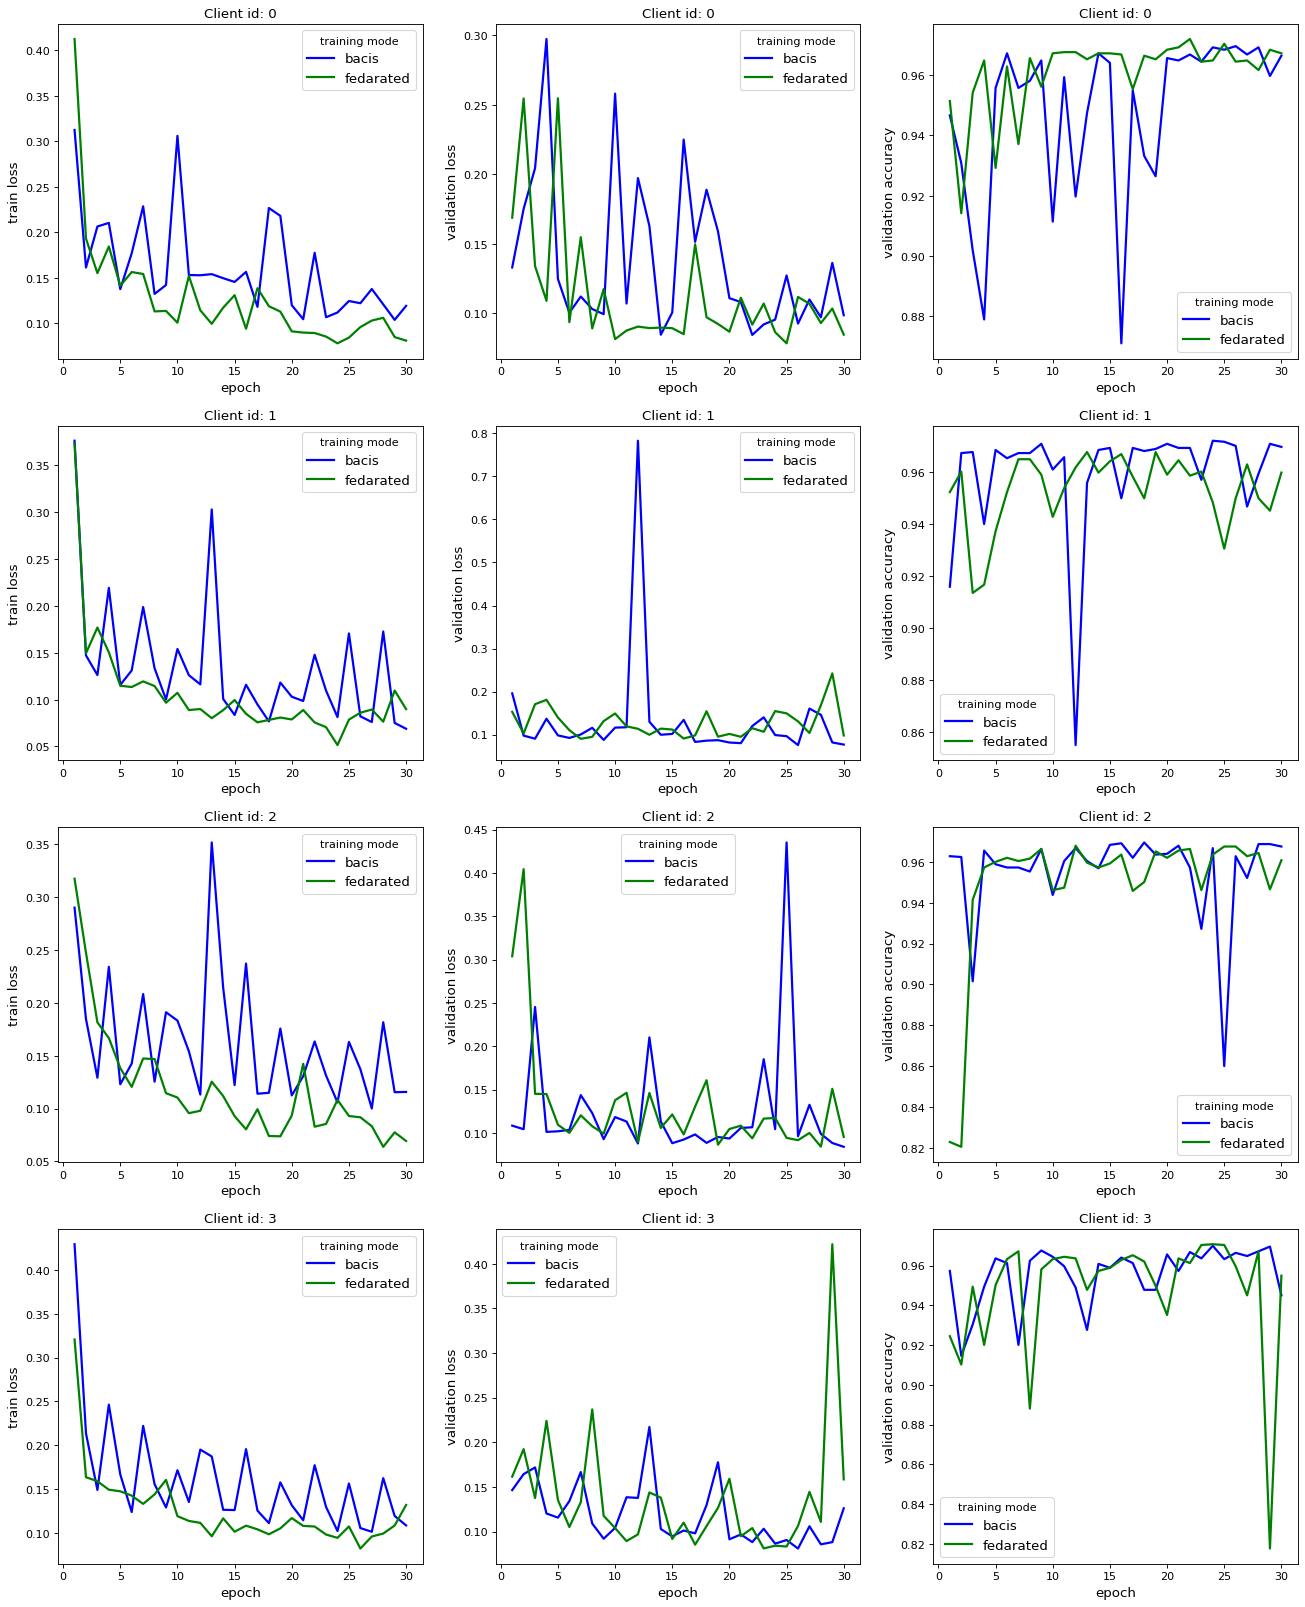

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,25), dpi=80)

for client_index in range(num_clients):
    client_id = server.clients[client_index].client_id
    types_of_evalution = federated_clients_history[client_index].keys()
    
    for eval_index, eval_type in enumerate(types_of_evalution, 1):
        plt.subplot(num_clients, len(types_of_evalution), len(types_of_evalution) * client_index + eval_index)
        
        federated_eval_values = federated_clients_history[client_index][eval_type]
        basic_eval_values = basic_clients_history[client_index][eval_type]

        plt.plot(range(1, len(federated_eval_values) + 1), federated_eval_values, color='b', label='bacis', linewidth=2)
        plt.plot(range(1, len(basic_eval_values) + 1), basic_eval_values, color='g', label='fedarated', linewidth=2)

        plt.title(f'Client id: {client_id}', fontsize=12)
        plt.xlabel('epoch', fontsize=12)
        plt.ylabel(str(eval_type), fontsize=12)

        plt.legend(title='training mode',  prop={'size': 12})
plt.savefig('results3.png')
plt.savefig('results3.pdf')
plt.show()


## Saving results

In [49]:
!zip -r working.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/results2.png (deflated 6%)
  adding: kaggle/working/federated_models/ (stored 0%)
  adding: kaggle/working/federated_models/client_id_0.pt (deflated 22%)
  adding: kaggle/working/federated_models/server.pt (deflated 8%)
  adding: kaggle/working/federated_models/client_id_3.pt (deflated 27%)
  adding: kaggle/working/federated_models/client_id_1.pt (deflated 16%)
  adding: kaggle/working/federated_models/client_id_2.pt (deflated 30%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/basic_models/ (stored 0%)
  adding: kaggle/working/basic_models/client_id_0.pt (deflated 9%)
  adding: kaggle/working/basic_models/client_id_3.pt (deflated 9%)
  adding: kaggle/working/basic_models/client_id_1.pt (deflated 9%)
  adding: kaggle/working/basic_models/client_id_2.pt (deflated 12%)
  adding: kaggle/working/results3.pdf (deflated 17%)
  adding: kaggle/working/results3.png (deflated 6%)
  adding: kaggle/wo

In [ ]:
from IPython.display import FileLink
FileLink(r'working.zip')
# results3.pdf

In [24]:
basic_clients_history = {0: {'train loss': [0.37630185,
   0.17976715,
   0.16273828,
   0.14579406,
   0.14994305,
   0.1368389,
   0.13065436,
   0.14795476,
   0.14535421,
   0.1155084,
   0.11473186,
   0.100176916,
   0.097105466,
   0.119945124,
   0.09667941,
   0.11820825,
   0.102364756,
   0.11147082,
   0.11760069,
   0.092582256,
   0.08430922,
   0.0926605,
   0.09783849,
   0.07736747,
   0.080571525,
   0.08338174,
   0.087954454,
   0.07252413,
   0.07152331,
   0.082056075],
  'validation loss': [0.30630127,
   0.19425252,
   0.1799936,
   0.111137584,
   0.12666298,
   0.1196806,
   0.21964718,
   0.40652093,
   0.14409302,
   0.15119573,
   0.08953102,
   0.102340914,
   0.15381716,
   0.15354192,
   0.10461579,
   0.11797929,
   0.11313929,
   0.10435118,
   0.13192396,
   0.10557587,
   0.23654585,
   0.10087806,
   0.10218285,
   0.14581938,
   0.18724449,
   0.12342506,
   0.11341259,
   0.08701036,
   0.33705184,
   0.12291657],
  'validation accuracy': [0.9165348101265823,
   0.928006329113924,
   0.9193037974683544,
   0.9572784810126582,
   0.959256329113924,
   0.9553006329113924,
   0.935126582278481,
   0.8864715189873418,
   0.9315664556962026,
   0.9517405063291139,
   0.9643987341772152,
   0.9604430379746836,
   0.9426424050632911,
   0.946993670886076,
   0.961629746835443,
   0.9600474683544303,
   0.9612341772151899,
   0.9612341772151899,
   0.9560917721518988,
   0.9632120253164557,
   0.9450158227848101,
   0.9608386075949367,
   0.9600474683544303,
   0.9489715189873418,
   0.9430379746835443,
   0.9568829113924051,
   0.9604430379746836,
   0.96875,
   0.9323575949367089,
   0.9636075949367089]},
 1: {'train loss': [0.2840213,
   0.1804378,
   0.14037924,
   0.1383284,
   0.15139823,
   0.12618639,
   0.14469896,
   0.09662936,
   0.13685666,
   0.13012868,
   0.1171621,
   0.09158425,
   0.11279957,
   0.13679941,
   0.09523627,
   0.08899873,
   0.10932239,
   0.097737856,
   0.0850141,
   0.14137457,
   0.075793944,
   0.09565274,
   0.088035375,
   0.07000556,
   0.066294365,
   0.05958382,
   0.07345355,
   0.09073196,
   0.090109706,
   0.066476315],
  'validation loss': [0.22284703,
   0.13202718,
   0.18873884,
   0.121142976,
   0.10894754,
   0.075635605,
   0.10285916,
   0.08239128,
   0.119985424,
   0.07581858,
   0.10576957,
   0.086565815,
   0.09062434,
   0.09171624,
   0.071187384,
   0.07345901,
   0.06677415,
   0.09196211,
   0.063976206,
   0.077927195,
   0.07683161,
   0.10932216,
   0.064030804,
   0.07028877,
   0.06188136,
   0.08012198,
   0.059467945,
   0.05490279,
   0.07499245,
   0.09775236],
  'validation accuracy': [0.899129746835443,
   0.9501582278481012,
   0.9371044303797469,
   0.9553006329113924,
   0.961629746835443,
   0.9679588607594937,
   0.9671677215189873,
   0.9691455696202531,
   0.9620253164556962,
   0.9750791139240507,
   0.9612341772151899,
   0.964003164556962,
   0.9691455696202531,
   0.9727056962025317,
   0.9719145569620253,
   0.9695411392405063,
   0.9731012658227848,
   0.9671677215189873,
   0.9770569620253164,
   0.9691455696202531,
   0.9746835443037974,
   0.9533227848101266,
   0.9766613924050633,
   0.973496835443038,
   0.9754746835443038,
   0.9699367088607594,
   0.9738924050632911,
   0.9746835443037974,
   0.9679588607594937,
   0.9643987341772152]},
 2: {'train loss': [0.24288477,
   0.14530167,
   0.14767332,
   0.14460449,
   0.12423132,
   0.10684826,
   0.097936966,
   0.11771666,
   0.09833792,
   0.09046449,
   0.07384466,
   0.07690949,
   0.08739238,
   0.08826983,
   0.078729615,
   0.07371419,
   0.07445558,
   0.04910056,
   0.081307866,
   0.0898359,
   0.07821605,
   0.058406875,
   0.062931225,
   0.0415101,
   0.049541194,
   0.04301353,
   0.057237353,
   0.07468373,
   0.045941547,
   0.053168412],
  'validation loss': [0.4860945,
   0.3293586,
   0.59777796,
   1.2510772,
   0.17480102,
   0.0712435,
   0.0913982,
   0.115055,
   0.062662765,
   0.10185213,
   0.049767956,
   0.15113792,
   0.046355847,
   0.04222651,
   0.059629224,
   0.043729696,
   0.047475923,
   0.044356275,
   0.072726384,
   0.040816434,
   0.041884687,
   0.04912746,
   0.039203305,
   0.04402367,
   0.052887097,
   0.037286766,
   0.043251332,
   0.039703827,
   0.043646805,
   0.050817274],
  'validation accuracy': [0.7879746835443038,
   0.84375,
   0.8231803797468354,
   0.8109177215189873,
   0.9137658227848101,
   0.9754746835443038,
   0.971123417721519,
   0.9564873417721519,
   0.9829905063291139,
   0.961629746835443,
   0.9806170886075949,
   0.9517405063291139,
   0.9849683544303798,
   0.9829905063291139,
   0.9715189873417721,
   0.9814082278481012,
   0.9861550632911392,
   0.9873417721518988,
   0.9746835443037974,
   0.9825949367088608,
   0.9869462025316456,
   0.9861550632911392,
   0.9881329113924051,
   0.9865506329113924,
   0.9814082278481012,
   0.9861550632911392,
   0.9865506329113924,
   0.9845727848101266,
   0.9818037974683544,
   0.9833860759493671]},
 3: {'train loss': [0.23123313,
   0.18977346,
   0.12368978,
   0.19940443,
   0.13542505,
   0.13084912,
   0.08615685,
   0.13216862,
   0.08831632,
   0.083210126,
   0.08342321,
   0.079122424,
   0.07880794,
   0.0985784,
   0.07191993,
   0.08170282,
   0.058058005,
   0.091160744,
   0.09930042,
   0.06991007,
   0.08361828,
   0.10218907,
   0.08635873,
   0.08091689,
   0.07586286,
   0.05843745,
   0.114677645,
   0.0774976,
   0.088711984,
   0.041755036],
  'validation loss': [0.07707782,
   0.08386554,
   0.10280189,
   0.22045802,
   0.09726608,
   0.06987086,
   0.058402013,
   0.096802376,
   0.059286118,
   0.06985257,
   0.070130676,
   0.048626557,
   0.05345001,
   0.051471077,
   0.05806516,
   0.04404878,
   0.051819365,
   0.054926153,
   0.048676264,
   0.10499322,
   0.049145814,
   0.10246183,
   0.07544753,
   0.051624153,
   0.041434404,
   0.0737445,
   0.049889866,
   0.04547848,
   0.052190743,
   0.038201947],
  'validation accuracy': [0.9679588607594937,
   0.9691455696202531,
   0.9596518987341772,
   0.9268196202531646,
   0.9620253164556962,
   0.9786392405063291,
   0.9786392405063291,
   0.9501582278481012,
   0.9821993670886076,
   0.975870253164557,
   0.9798259493670886,
   0.9778481012658228,
   0.9841772151898734,
   0.9825949367088608,
   0.9802215189873418,
   0.9865506329113924,
   0.9786392405063291,
   0.9786392405063291,
   0.9849683544303798,
   0.9541139240506329,
   0.9833860759493671,
   0.9703322784810127,
   0.973496835443038,
   0.9790348101265823,
   0.9869462025316456,
   0.9766613924050633,
   0.9825949367088608,
   0.9798259493670886,
   0.9770569620253164,
   0.9849683544303798]}}

In [25]:
federated_clients_history = {0: {'train loss': [0.20985664,
   0.14517646,
   0.12752485,
   0.20320238,
   0.12534857,
   0.11238024,
   0.15828091,
   0.12443987,
   0.13929404,
   0.27561542,
   0.10610238,
   0.12457475,
   0.16995807,
   0.10498533,
   0.12680115,
   0.18055767,
   0.10558371,
   0.09033069,
   0.117347255,
   0.10820746,
   0.08986674,
   0.17668018,
   0.10082074,
   0.085863695,
   0.19472075,
   0.08916023,
   0.06905739,
   0.0991337,
   0.11234831,
   0.09124865],
  'validation loss': [0.16503915,
   0.1660178,
   0.09518049,
   0.098938294,
   0.08529709,
   0.09812916,
   0.25631574,
   0.12384929,
   0.15985744,
   0.11426935,
   0.22130068,
   0.117384195,
   0.09902848,
   0.15941446,
   0.14155392,
   0.122539826,
   0.10466823,
   0.08896082,
   0.106693916,
   0.0846418,
   0.17362311,
   0.09028944,
   0.1866295,
   0.08444292,
   0.1506944,
   0.097805925,
   0.09562901,
   0.086115934,
   0.08401406,
   0.08179234],
  'validation accuracy': [0.9458069620253164,
   0.9572784810126582,
   0.9636075949367089,
   0.9604430379746836,
   0.9659810126582279,
   0.9604430379746836,
   0.928006329113924,
   0.9513449367088608,
   0.930379746835443,
   0.9533227848101266,
   0.9299841772151899,
   0.9549050632911392,
   0.9655854430379747,
   0.9462025316455697,
   0.9359177215189873,
   0.9612341772151899,
   0.9647943037974683,
   0.9679588607594937,
   0.9647943037974683,
   0.9651898734177216,
   0.9541139240506329,
   0.9643987341772152,
   0.9386867088607594,
   0.9703322784810127,
   0.9462025316455697,
   0.9683544303797469,
   0.96875,
   0.9612341772151899,
   0.9659810126582279,
   0.9655854430379747]},
 1: {'train loss': [0.209125,
   0.10825751,
   0.14047928,
   0.15399127,
   0.12340904,
   0.1347376,
   0.16268608,
   0.12940593,
   0.1402512,
   0.12809514,
   0.12748668,
   0.11877821,
   0.15229046,
   0.12449538,
   0.107086696,
   0.11170583,
   0.11698905,
   0.0963958,
   0.16736588,
   0.08416884,
   0.094556816,
   0.09543986,
   0.12290466,
   0.1286368,
   0.13577819,
   0.1326148,
   0.09643301,
   0.16339011,
   0.08464214,
   0.084552914],
  'validation loss': [0.19131076,
   0.11511711,
   0.15700133,
   0.085657686,
   0.09025609,
   0.10228961,
   0.18284768,
   0.12521629,
   0.113107756,
   0.14821242,
   0.083722256,
   0.110976934,
   0.085255936,
   0.09241694,
   0.07998716,
   0.09319555,
   0.080746025,
   0.08646591,
   0.082595594,
   0.07568677,
   0.07420077,
   0.07480733,
   0.1177076,
   0.0872897,
   0.09074356,
   0.06903113,
   0.0921858,
   0.09743166,
   0.09138758,
   0.07297187],
  'validation accuracy': [0.9236550632911392,
   0.9608386075949367,
   0.9651898734177216,
   0.9624208860759493,
   0.964003164556962,
   0.9588607594936709,
   0.9240506329113924,
   0.9485759493670886,
   0.961629746835443,
   0.9375,
   0.9659810126582279,
   0.9624208860759493,
   0.9703322784810127,
   0.971123417721519,
   0.9691455696202531,
   0.964003164556962,
   0.9699367088607594,
   0.96875,
   0.9647943037974683,
   0.9738924050632911,
   0.9671677215189873,
   0.9762658227848101,
   0.961629746835443,
   0.96875,
   0.9628164556962026,
   0.975870253164557,
   0.9647943037974683,
   0.9679588607594937,
   0.9612341772151899,
   0.9715189873417721]},
 2: {'train loss': [0.2362965,
   0.14948675,
   0.15028997,
   0.1870685,
   0.10140314,
   0.11256552,
   0.13969919,
   0.10825353,
   0.09904802,
   0.1417868,
   0.12218371,
   0.103332534,
   0.10921071,
   0.088802725,
   0.094681755,
   0.12316766,
   0.10624923,
   0.08618148,
   0.095382474,
   0.06591922,
   0.07642387,
   0.09164779,
   0.07786109,
   0.08273981,
   0.09390396,
   0.059304386,
   0.07839562,
   0.08562257,
   0.09535997,
   0.06411158],
  'validation loss': [0.23754917,
   0.27156442,
   0.8100755,
   1.4084238,
   0.3885027,
   0.0616767,
   0.09662459,
   0.06928839,
   0.052878983,
   0.0547994,
   0.087065876,
   0.06087582,
   0.08125385,
   0.058400057,
   0.15270351,
   0.05250748,
   0.07877281,
   0.056922443,
   0.041382033,
   0.04616712,
   0.045938153,
   0.08964408,
   0.044832647,
   0.055655044,
   0.053090796,
   0.038552605,
   0.051811405,
   0.047812574,
   0.05543879,
   0.03813577],
  'validation accuracy': [0.8931962025316456,
   0.8876582278481012,
   0.8128955696202531,
   0.836629746835443,
   0.8864715189873418,
   0.978243670886076,
   0.9636075949367089,
   0.9810126582278481,
   0.9841772151898734,
   0.9849683544303798,
   0.9679588607594937,
   0.9794303797468354,
   0.9770569620253164,
   0.9794303797468354,
   0.9378955696202531,
   0.9810126582278481,
   0.9723101265822784,
   0.9719145569620253,
   0.9841772151898734,
   0.9833860759493671,
   0.9857594936708861,
   0.966376582278481,
   0.9861550632911392,
   0.9837816455696202,
   0.9742879746835443,
   0.9861550632911392,
   0.9790348101265823,
   0.9845727848101266,
   0.9810126582278481,
   0.9881329113924051]},
 3: {'train loss': [0.29701447,
   0.16225152,
   0.12147098,
   0.20572793,
   0.14809626,
   0.11290094,
   0.1760533,
   0.10140439,
   0.10367418,
   0.13786723,
   0.09390798,
   0.096105196,
   0.091387756,
   0.08458218,
   0.11758789,
   0.1605045,
   0.07561068,
   0.09078515,
   0.12056199,
   0.06781629,
   0.09198991,
   0.15919408,
   0.0834343,
   0.08931366,
   0.13471852,
   0.090525754,
   0.06816472,
   0.108668186,
   0.06239922,
   0.06934632],
  'validation loss': [0.1428515,
   0.111003004,
   0.06507836,
   0.1271571,
   0.08985891,
   0.07626439,
   0.08552012,
   0.06254745,
   0.06165007,
   0.06158528,
   0.08078743,
   0.30392906,
   0.0565377,
   0.046163484,
   0.09064486,
   0.06509325,
   0.08351193,
   0.04905639,
   0.06499153,
   0.06745881,
   0.053155743,
   0.063547514,
   0.06515689,
   0.0462027,
   0.04790779,
   0.037484713,
   0.07072902,
   0.051464804,
   0.05092499,
   0.05714112],
  'validation accuracy': [0.9485759493670886,
   0.9691455696202531,
   0.9754746835443038,
   0.9517405063291139,
   0.9731012658227848,
   0.973496835443038,
   0.9683544303797469,
   0.9762658227848101,
   0.9770569620253164,
   0.978243670886076,
   0.9727056962025317,
   0.8892405063291139,
   0.9849683544303798,
   0.9821993670886076,
   0.9798259493670886,
   0.9818037974683544,
   0.9675632911392406,
   0.9825949367088608,
   0.9794303797468354,
   0.9810126582278481,
   0.9853639240506329,
   0.9786392405063291,
   0.9794303797468354,
   0.9841772151898734,
   0.9833860759493671,
   0.9794303797468354,
   0.9762658227848101,
   0.9818037974683544,
   0.9837816455696202,
   0.9790348101265823]}}

In [16]:
basic_clients_history[0]['validation accuracy'][-5:]

[0.9568829113924051,
 0.9604430379746836,
 0.96875,
 0.9323575949367089,
 0.9636075949367089]

In [48]:
import numpy as np
num_clients = 4
for client_index in range(num_clients):
    # for eval_type in basic_clients_history[0].keys():
    last_mean_accuracy_before = np.mean(basic_clients_history[client_index]['validation accuracy'][-10:])
    last_mean_accuracy_after = np.mean(federated_clients_history[client_index]['validation accuracy'][-10:])
    
    var_val_loss_before = np.var(basic_clients_history[client_index]['validation accuracy'])
    var_val_loss_after = np.var(federated_clients_history[client_index]['validation accuracy'])
    
    print('Cliend {} \n Mean:\n before: {:.3f} \n after: {:.3f} \n Var: \n before: {:.4f} \n after: {:.4f}'.format(client_index, last_mean_accuracy_before, last_mean_accuracy_after, var_val_loss_before, var_val_loss_after))


Cliend 0 
 Mean:
 before: 0.967 
 after: 0.966 
 Var: 
 before: 0.0002 
 after: 0.0007
Cliend 1 
 Mean:
 before: 0.953 
 after: 0.965 
 Var: 
 before: 0.0002 
 after: 0.0005
Cliend 2 
 Mean:
 before: 0.961 
 after: 0.950 
 Var: 
 before: 0.0012 
 after: 0.0005
Cliend 3 
 Mean:
 before: 0.948 
 after: 0.963 
 Var: 
 before: 0.0009 
 after: 0.0002
